### Work and Health
1. Importing the data
    1. Functions to filter & clean the data
2. Pre-process the data
    1. Missing Values
    2. Outliers
3. Feature Engineering
4. In depth-exploration
5. Cluter Analysis
    1. Transform the data
    2. Check for optimal K
    3. Apply K-means and interpret results
  

In [1]:
#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor
plt.style.use('ggplot')
#C:\Users\lsove\OneDrive\Documentos

### Brief summary of the data-sets

In [2]:
summary_df = pd.read_excel('../raw data/Data_set_desc.xlsx')

In [82]:
list(summary_df.description[summary_df.index ==1])

['Total weekly hours worked of employed persons (thousands)']

### Import diseases data

In [6]:
df_diseases_1 = pd.read_csv('../raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-1/IHME-GBD_2019_DATA-16b07a3d-1.csv')
df_diseases_2 = pd.read_csv('../raw data//Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-2/IHME-GBD_2019_DATA-16b07a3d-2.csv')
df_diseases = df_diseases_1.append(df_diseases_2).reset_index()
df_diseases.drop(columns = 'index', inplace = True)

### Function to filter usefull disease data

In [7]:
#data cleaning - function that receives year of analysis, gender, metric and measure. Returns the "cleaned" df

def get_df_dis(df,year,gender,metric,measure):
    
    year = int(year)
    
    #drop redundant columns (code for each feature, mainly)
    df.copy().drop(columns=['measure_id','location_id','measure_name','sex_id','age_id','age_name','cause_id','metric_id'\
                         ,'upper','lower'], inplace=True)
    
    #filter by gender and year (Male or Female)
    df = df.loc[df_diseases['sex_name'].isin([gender])]\
.loc[df_diseases['year'] == year].drop(columns=['sex_name','year']).copy()
    
    #filter by metric (Number, Percent or Rate)
    df = df.loc[df.metric_name == metric].copy()
    df.drop(columns = ['metric_name'],inplace = True)
    
    #filter by measure (Incidence or Prevalence)
    df = df.loc[df.measure_name == measure].copy()
    df.drop(columns = ['measure_name'],inplace = True)
    
    #pivoting table with disease names = columns
    df = df.copy().pivot(index='location_name', columns = 'cause_name', values = 'val')
    
    df.drop(columns = ['Stroke','Headache disorders'],inplace = True)
    
    df.rename(columns={'Anxiety disorders':'Anxiety_disorder','Bipolar disorder':'Bipolar_disorder',\
                      'Depressive disorders':'Depressive_disorders','Musculoskeletal disorders':\
                      'Musculoskeletal_disorders'}, inplace=True)
    
    return df

### Import health cost data

In [8]:
df_health_cost = pd.read_excel('../raw data/Health_expenditure_WB/Health_expenditure_WB.xls',na_values='..')

### Function to filter usefull HC data

In [9]:
def get_df_hc(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SH.XPD.GHED.PP.CD':'Public_cost','SH.XPD.PVTD.PP.CD':'Private_cost'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import GDP p/capita data

In [10]:
df_gdp = pd.read_excel('../raw data/GPD_WB/GPD_CAPITA_WB.xlsx',na_values='..')

### Function to filter usefull GDP data

In [11]:
def get_gdp(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'NY.GDP.PCAP.CD':'GDP_PC'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import Employment data

In [12]:
df_employment = pd.read_excel('../raw data/Employment_WB_2/Employment_WB_2.xlsx',na_values='..')

### Function to filter usefull employment data

In [13]:
def get_employment(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename columns for better readability
    df.rename(columns={'SL.AGR.EMPL.FE.ZS':'per_female_agriculture',\
                      'SL.AGR.EMPL.MA.ZS':'per_male_agriculture',\
                      'SL.AGR.EMPL.ZS':'per_total_agriculture',\
                      'SL.EMP.TOTL.SP.ZS':'per_total_employment',\
                      'SL.EMP.TOTL.SP.MA.ZS':'per_male_employment',\
                      'SL.EMP.TOTL.SP.FE.ZS':'per_female_employment',\
                      'SL.IND.EMPL.FE.ZS':'per_female_industry',\
                      'SL.IND.EMPL.MA.ZS':'per_male_industry',\
                      'SL.IND.EMPL.ZS':'per_total_industry',\
                      'SL.SRV.EMPL.FE.ZS':'per_female_services',\
                      'SL.SRV.EMPL.MA.ZS':'per_male_services',\
                      'SL.SRV.EMPL.ZS':'per_total_services'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Unemployment & Labor force data

In [14]:
df_unemp_lforce = pd.read_excel('../raw data/UNEMP_LABORFORCE/unemp_lforce.xlsx',na_values='..')

In [15]:
def get_unemp_lforce(df,year):
        #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SL.TLF.CACT.ZS':'Total_Labor_Force', 'SL.UEM.TOTL.ZS':'Unemployment_rate'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Hours worked

In [16]:
df_hours_work = pd.read_excel('../raw data/HOURS_ILO/HOURS_ILO.xlsx',na_values='..')

In [17]:
def get_hours_work(df,year):
    
    year = int(year)
        
    # remove unnecessary years
    df = df[['ref_area.label','obs_value']].loc[df.time == year].copy()
    
    df.set_index('ref_area.label', inplace = True)
    
    df = df.rename_axis('location_name')
        
    df.rename(columns={'obs_value':'Weekly_work_hours'}, inplace = True)
    
    df['Weekly_work_hours'] =  df['Weekly_work_hours']*1000
    
    return df

### Population size

In [18]:
df_pop = pd.read_excel('../raw data/Population/Population.xlsx',na_values='..')

In [19]:
def get_pop(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SP.POP.0014.TO':'Pop_Under15','SP.POP.TOTL':'Pop_Total'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    df['Pop_Over15'] = (df['Pop_Total']-df['Pop_Under15'])
    
    df.drop(columns =['Pop_Total','Pop_Under15'],inplace = True)
    
    return df

### SUMMARY OF ALL DATA GATHERED

### Function to merge all data frames depending on the year

In [102]:
# Getting all filtered df's
def merge2complete (year):
    
    df1 = get_df_dis(df_diseases,year,'Both','Rate','Incidence')
    df2 = get_df_hc(df_health_cost,year)
    df3 = get_gdp(df_gdp,year)
    df4 = get_employment(df_employment,year)
    df5 = get_unemp_lforce(df_unemp_lforce,year)
    df6 = get_hours_work(df_hours_work,year)
    df7 = get_pop(df_pop,year)
    
    #merge with inner join on the location

    df8 = pd.merge(df1,df2, on='location_name', how='inner')
    df9 = pd.merge(df8,df3, on='location_name', how='inner')
    df10 = pd.merge(df9,df4, on='location_name', how='inner')
    df11 = pd.merge(df10,df5, on='location_name', how='inner')
    df12 = pd.merge(df11,df6, on='location_name', how='inner')
    df13 = pd.merge(df12,df7, on='location_name', how='inner')

    #remove gender related columns:
    col_remove = ['per_female_agriculture','per_male_agriculture','per_male_employment','per_female_employment',\
                 'per_female_industry','per_male_industry','per_female_services','per_male_services']
    complete = df13.drop(columns = col_remove)
    
    return complete

### Evaluate Outliers

In [103]:
def eval_outliers(df,columns):
    # check distribution of feature with highest kurtosis/skewness
    fig, axes = plt.subplots(1,len(columns), figsize = (14,6))
    for i,col_name in enumerate(columns):
        sns.boxplot(ax = axes[i], data = df, x = col_name).set(title=col_name)
    plt.show()
    
    return pd.DataFrame({'skew':df.skew(),'kurt':df.kurt()})

### Missing Values

In [104]:
def predict_missing(df, evaluated_column):
    """ Predicts and updates the missing values for the different features. """
    
    cols = list(df.isna().sum()[df.isna().sum() != 0].index)
    
    # removes the evaluated feature
    cols.remove(evaluated_column)
    
    # defines the data to be used using the gradiant boosting method
    gb_data = df.select_dtypes(exclude=['object']).drop(columns = cols)
    
    # divides the data in missing and complete values
    feature_na = gb_data.loc[gb_data[evaluated_column].isna()]
    feature = gb_data.loc[~gb_data[evaluated_column].isna()]
    
    # defines the training data
    x_train = feature.drop(columns = evaluated_column)
    y_train = feature.copy().pop(evaluated_column)
    
    # fits the model
    gb = GradientBoostingRegressor(n_estimators=100)
    gb.fit(x_train, y_train)
    
    # predicts missing values
    x_predict = feature_na.drop(columns = evaluated_column)
    pred = pd.DataFrame(gb.predict(x_predict), index=x_predict.index, columns=[f'{evaluated_column}_na'])
    
    # fills the na values
    df = df.merge(pred, left_index=True, right_index=True, how='left')
    df.loc[df[evaluated_column].isna(), evaluated_column] = df[f'{evaluated_column}_na']
    df.drop(columns = [f'{evaluated_column}_na'], inplace=True)
    
    return df

### Feature Engineering

In [138]:
def feature_df(df,year):
    
 #group all mental disordes in new variable
    df['mental_disorders'] = df['Anxiety_disorder']+df['Bipolar_disorder']+df['Depressive_disorders']
    
    #group all costs in one single cost variable
    df['total_health_cost']=df['Private_cost']+df['Public_cost']
    
    #group all diseases in single total diseases var
    df['all_disorders'] = df['mental_disorders']+df['Musculoskeletal_disorders']+df['Dermatitis']
    
    #normalize variables PER CAPITA
    #per_total_employment: Employment to population ratio, 15+, total (%)
    #per_total_sector: Employment in each sector (% of total employment)
    
    #df['agriculture_PC'] = (df['per_total_employment']*df['per_total_agriculture'])/10000
    #df['industry_PC'] = (df['per_total_employment']*df['per_total_industry'])/10000
    #df['services_PC'] = (df['per_total_employment']*df['per_total_services'])/10000
    
    #unemployment is per total work force & labor force is per capita.
    df['Unemp_PC'] = (df['Unemployment_rate']*df['Total_Labor_Force'])/10000
    
    
    df['Week_hours_PC'] = df['Weekly_work_hours']/(df['Pop_Over15']*(df['per_total_employment'])/100)
    
    #df.drop(columns=['Anxiety_disorder','Bipolar_disorder','Depressive_disorders',\
    #                 'Public_cost','Private_cost','per_total_agriculture',\
    #                'per_total_industry','per_total_services',\
    #                'Total_Labor_Force','Unemployment_rate'],inplace=True)
    
    df.drop(columns=['Weekly_work_hours','Pop_Over15','Anxiety_disorder','Bipolar_disorder','Depressive_disorders',\
                     'Public_cost','Private_cost',\
                    'Total_Labor_Force','Unemployment_rate'],inplace=True)
    
    
    #correlation map
    sns.set(font_scale=1.3)
    df_corr = df.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g').set(title=year)
    plt.show()
    
    return df

### Clustering:
1. evaluate correlations
2. evaluate normality & apply transformations
3. evaluate K
4. evaluate clusters, knowing K

In [37]:
def evaluate_features(df,columns):
    #temp = feature_df(df.copy())[columns]
    
    #correlation heatmap:
    sns.set(font_scale=1.3)
    df_corr = df.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g')
    
    #pairplots:
    sns.pairplot(df[columns])
    
    plt.show()    

In [25]:
def pt_evaluation(df, evaluated_column):
    """ Evaluates the defined feature before and after applying power transformation. """
    
    # defining the power transformation class
    pt = PowerTransformer()

    # creating the evaluation data frame
    feature = df[[evaluated_column]]
    feature = feature.assign(log_transformation = np.log(feature[evaluated_column] + 1))
    feature = feature.assign(sqrt_transformation = np.sqrt(feature[evaluated_column]))
    feature = feature.assign(cbrt_transformation = np.cbrt(feature[evaluated_column]))
    #feature = feature.assign(yeo_johnson = pt.fit_transform(np.array(feature[evaluated_column]).reshape(-1, 1)))
    
    # represent the data
    fig, axes = plt.subplots(1, 4, figsize=(25, 6))
    sns.histplot(data=feature, x=evaluated_column,  ax=axes[0])
    sns.histplot(data=feature, x='sqrt_transformation', ax=axes[1], legend=False)
    sns.histplot(data=feature, x='cbrt_transformation', ax=axes[2], legend=False)
    sns.histplot(data=feature, x='log_transformation', ax=axes[3], legend=False)
    #sns.histplot(data=feature, x='yeo_johnson', ax=axes[4], legend=False)

In [26]:
def evaluate_number_clusters(df, n):
    """ Evaluates the kmeans using different values of k. """
    
    # evalaution result list
    evaluation = []
    
    # evaluates different number of clusters
    for k in range(2, n):    

        # performs the kmeans cluster using the defined number of clusters
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        silhoutte_score = silhouette_score(df, kmeans.labels_)

        # appends the results to the 
        evaluation.append([k, kmeans.inertia_, silhoutte_score])

    # converts the evaluation do df
    evaluation = pd.DataFrame(evaluation, columns=['k', 'error', 'silhouette'])

    # plots the evaluation
    fig, axes = plt.subplots(2,1, figsize = (14,6))
    sns.lineplot(data=evaluation, x='k', y='error', ax=axes[0], markers=True, marker="o")
    sns.lineplot(data=evaluation, x='k', y='silhouette', ax=axes[1], markers=True, marker="o")
    
    # saves the evaluation
    #fig.savefig(f'{prefix}_number_of_clusters_evaluation.png')

In [27]:
def evaluate_cluster(df_cluster, df_evaluate, k):
    """ Evaluate a specific number of cluster. """ 
    
    # applies the kmeans with specific number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)
    labels = kmeans.labels_
    
    # updates the cluster data
    df_cluster = df_cluster.assign(cluster = labels)
    
    # defines the number of columns to be evaluated
    columns = df_cluster.columns[:-1]
    n_columns = len(columns)
    
    # defines the standard height and width of the graphs
    graph_height = 6
    praph_width = 6
    
    # defines the number of columns and rows to be ploted
    n_columns_subplot = n_columns if n_columns <= 3 else 3
    if n_columns // 3 == 0 and n_columns != 3:
         n_rows_subplot = 1
    elif n_columns // 3 != 0 and n_columns % 3 == 0:
        n_rows_subplot = n_columns // 3 
    else:
        n_rows_subplot = n_columns // 3 + 1

    # calculates the total heigh and width
    total_height = graph_height * n_rows_subplot
    total_width = praph_width * n_columns_subplot
    
    # creates the subplot structure
    fig, axes = plt.subplots(n_rows_subplot, n_columns_subplot, figsize=(total_width, total_height))
    
    # defines the initial axis location of the plots
    if n_rows_subplot == 1:
        p = 0
    else:
        r = 0
        c = 0
    
    # plots all the columns
    for column in columns:
        if n_rows_subplot == 1:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[p], fill=True)
            p += 1
        else:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[r, c], fill=True)
            if c == n_columns_subplot-1:
                r += 1
                c = 0
            else:
                c += 1
            
    # saves the plot
    
    # shows the plot
    plt.show()
    
    # updates the evalutiaon data
    df_evaluate = df_evaluate.assign(labels=kmeans.labels_)
    
    # defines the evalaution metrics for each cluster
    metrics = {'labels': 'count'}
    for column in df_evaluate.columns:
        if column != 'labels':
            metrics[column] = ['mean', 'median']
    results = df_evaluate.groupby('labels').agg(metrics).round(2)
    
    return results

## Analysis for 2017


In [139]:
df_17 = merge2complete('2017')

### Basic Exploration

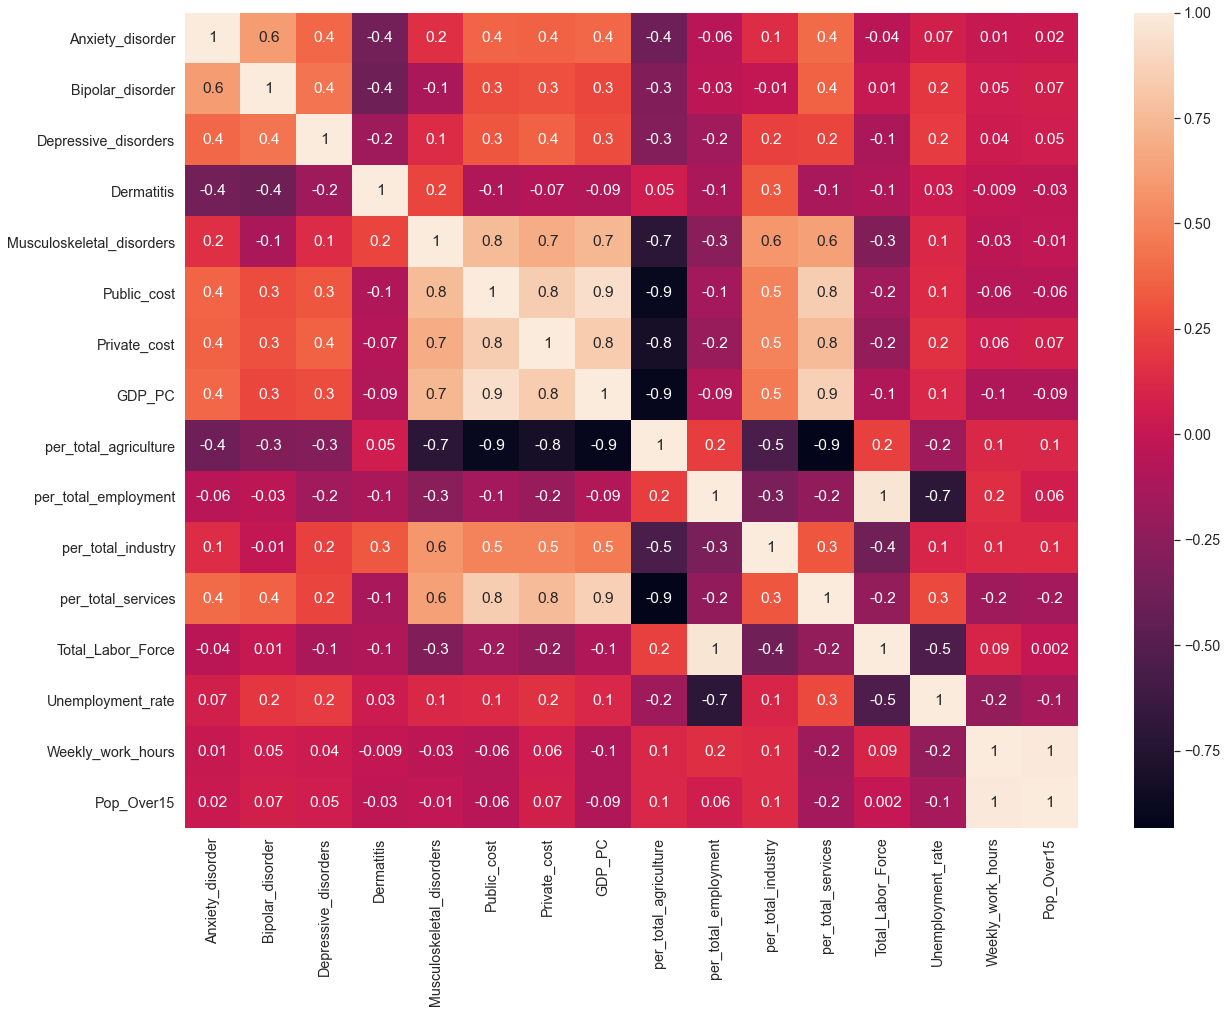

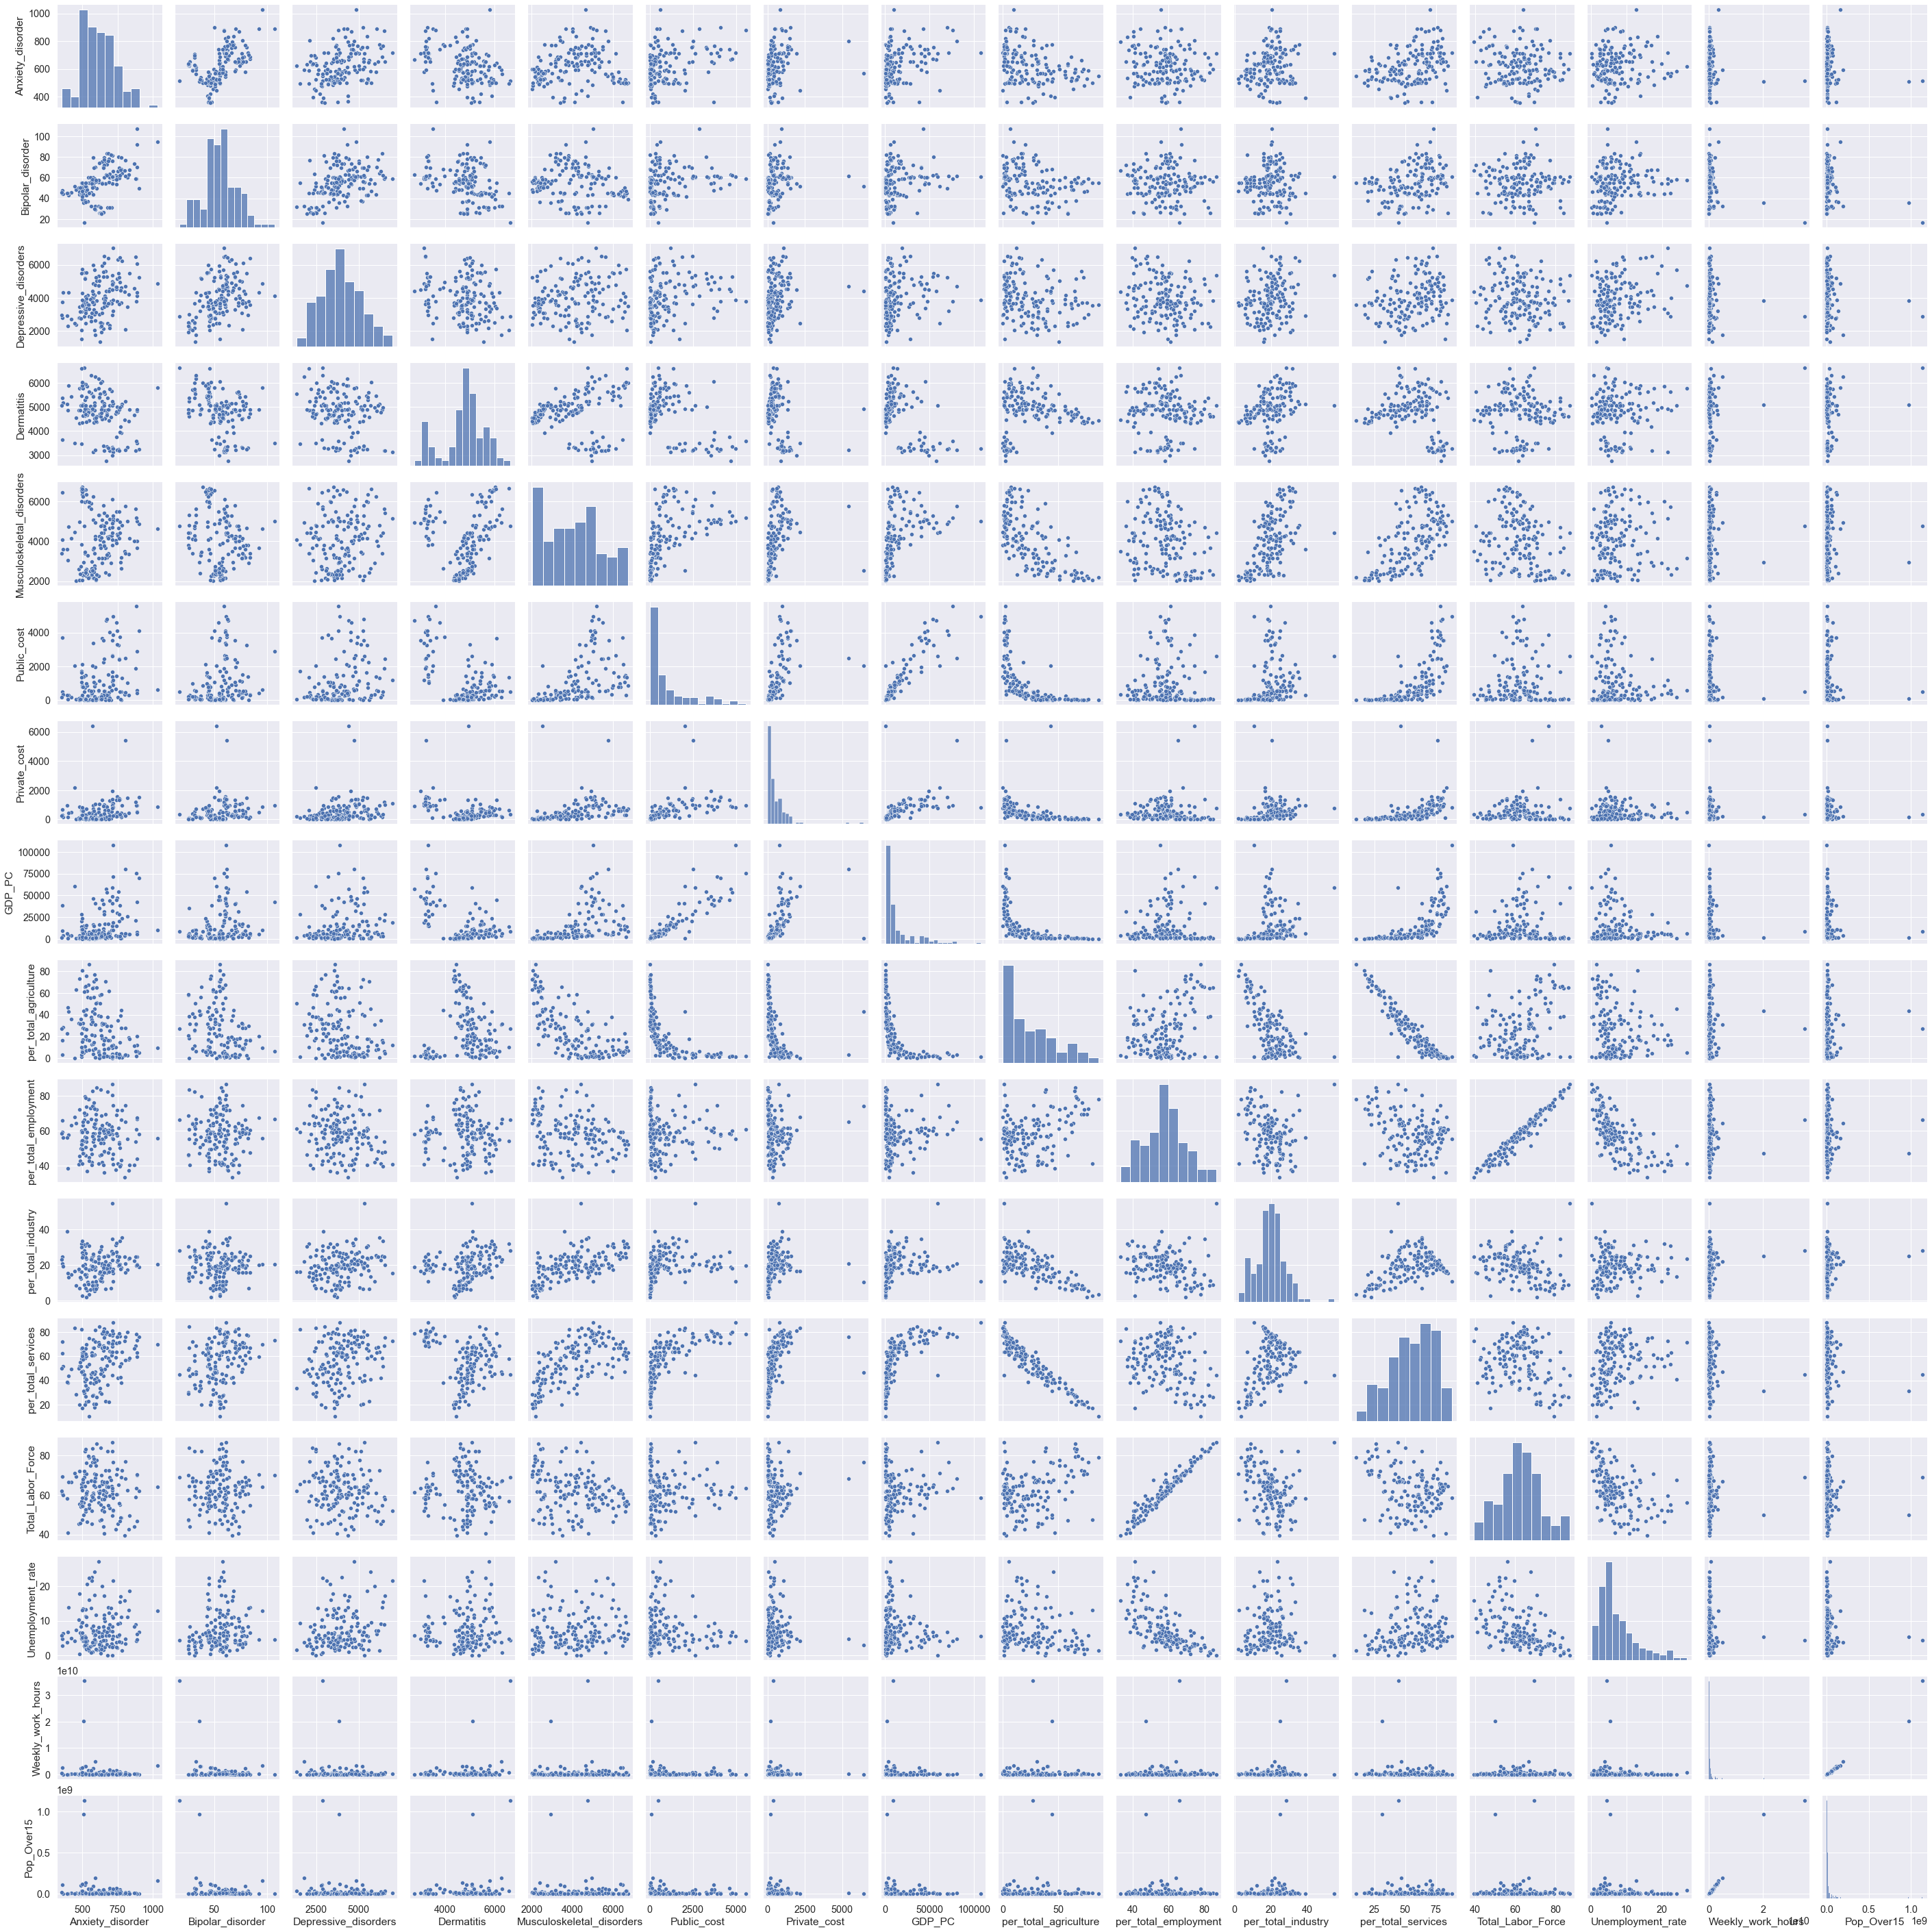

In [140]:
evaluate_features(df_17,list(df_17.columns))

### Interesting correlations:
	
* Musc. Disorders & GDP_PC -> 0,7
* Musc. Disorders & Public_Cost -> 0,8
* Musc. Disorders & Private_Cost -> 0,7
* Musc. Disorders & per_total_agric -> -0,7
	
* Public_Cost & per_total_services -> 0,8
* Public_Cost & per_total_agriculture -> -0,9
* Public_Cost & GDP_PC -> 0,9
* Public_Cost & Private_Cost -> 0,8
	
* Private_Cost & per_total_services -> 0,8
* Private_Cost & per_total_agriculture -> -0,8
* Private_cost & GDP_PC -> 0,8
	
* GDP_PC & per_total_services -> 0,9
* GDP_PC & per_total_agric -> -0,9
	
* per_total_agriculture & per_total_services -> -0,9
	
* per_total_employment & Week_hours_PC -> 0,8
* per_total_employment & Unemp_rate -> -0,7
	
* Anxiety & Bipolar -> 0,6

#### Musc. Disorders & per_total_agriculture
* Negative correlation (-0.7)
* The more percentage the country has in agriculture, the less musc. diseases they have

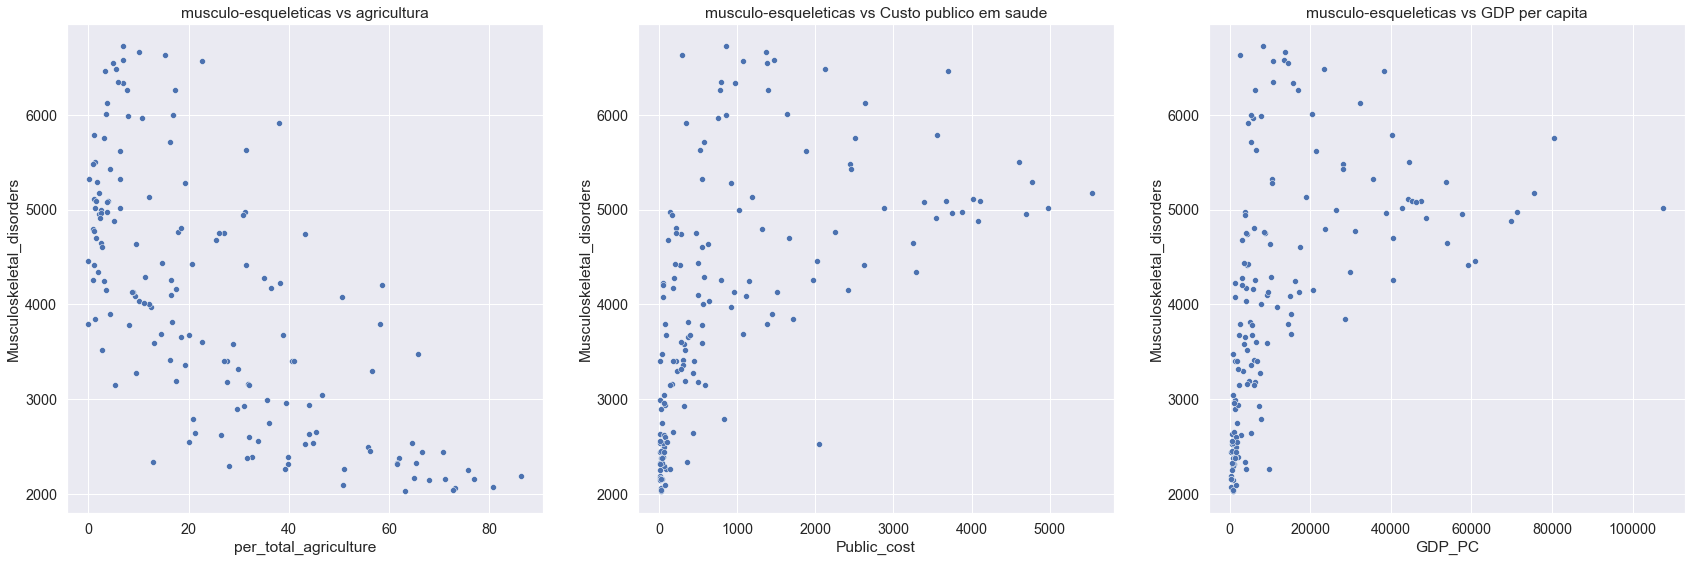

In [141]:

fig, axes = plt.subplots(1, 3, figsize=(29, 9))

sns.scatterplot(data=df_17, x='per_total_agriculture',y= 'Musculoskeletal_disorders', ax=axes[0]).set_title('musculo-esqueleticas vs agricultura')
sns.scatterplot(data=df_17, x='Public_cost',y= 'Musculoskeletal_disorders', ax=axes[1]).set_title('musculo-esqueleticas vs Custo publico em saude')
sns.scatterplot(data=df_17, x='GDP_PC',y= 'Musculoskeletal_disorders', ax=axes[2]).set_title('musculo-esqueleticas vs GDP per capita')

plt.show()


* Countries with higher incidence of Musculoskeletical diseases are the ones that have:
1. smaller agriculture sector share of employees
2. Spend more in public health costs
3. Higher GDP_PC (more developped countries might mean less agriculture)

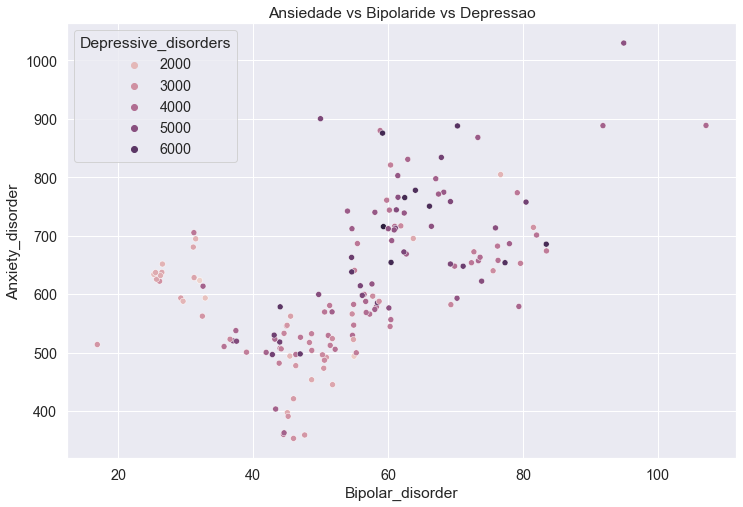

In [142]:
plt.figure(figsize=(12,8))

sns.scatterplot(data=df_17, x='Bipolar_disorder',y= 'Anxiety_disorder', hue = 'Depressive_disorders')\
.set_title('Ansiedade vs Bipolaride vs Depressao')
                
plt.show()

* Countries with higher incidence of Bipolar disorders are also the ones with higher incidence of Anxiety Disorders. Since these are both work related menatal diseases, we are going to group them into a single "mental disorder" category along with depression disorders (which has a positive correlation - although of smaller magnitude with the previous ones)

### Feature engineering

#### Feature Engineering steps:

1. Group all mental diseases (incidences per 100000 pp) in a single variable:
    * __mental_disorders = anxiety_disorder + bipolar_disorder + depressive_disorder__
2. Group Public_cost and Private_Cost in a single variable:
    * __total_health_cost = Private_cost + Public_cost__
4. the unemployment rate is a percentage over the total labor force. If we multiply it by the percentage of labor force over the whole population, we get the unemployment rate per Capita (__Unemp_PC__)
5. The variable __Weekly_work_hours__ is the complete amount of hours worked by employed persons on average per country. If we divide it by the number of employed persons, we get the average amount of hours worked per person (__Week_hours_PC__)

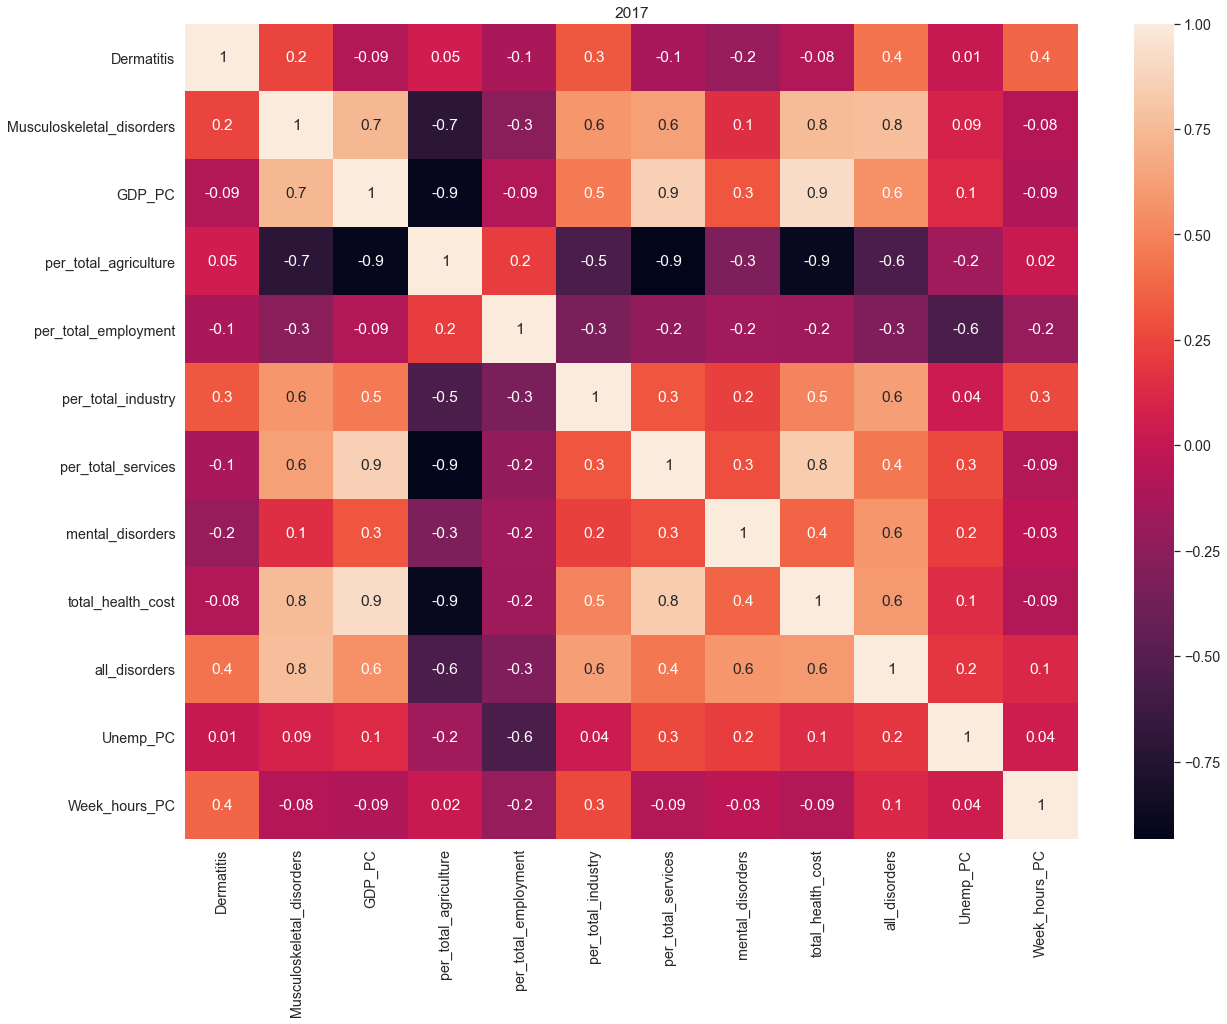

In [143]:
df_17_feat = feature_df(df_17,'2017')

### Exploration with new features

* __all_disorders__(total incidence of work related disorders) shows:
    1. Some correlation with the __GDP_PC__ (0.6) -> Countries with higher GDP tend to have more work related disorders.
    2. Some correlation with __total_health_cost__ (0.6) --> Countries with higher incidence on work related disorders tend to spend more money in health (these are also countries that tend to have higher GDP and therefore more developped)
    3. Some correlation with __per_total_industry__ (0.6) --> Countries with higher share in industry tend to have more work related disorders and less __per_total_agriculture__ (-0.6)
    
* __Week_hours_PC__ (average amount of hours worked per an employed person) shows:
    1. almost unexisting correlation with all variables except with Dermatitis (but still low correlation = 0.4)
    

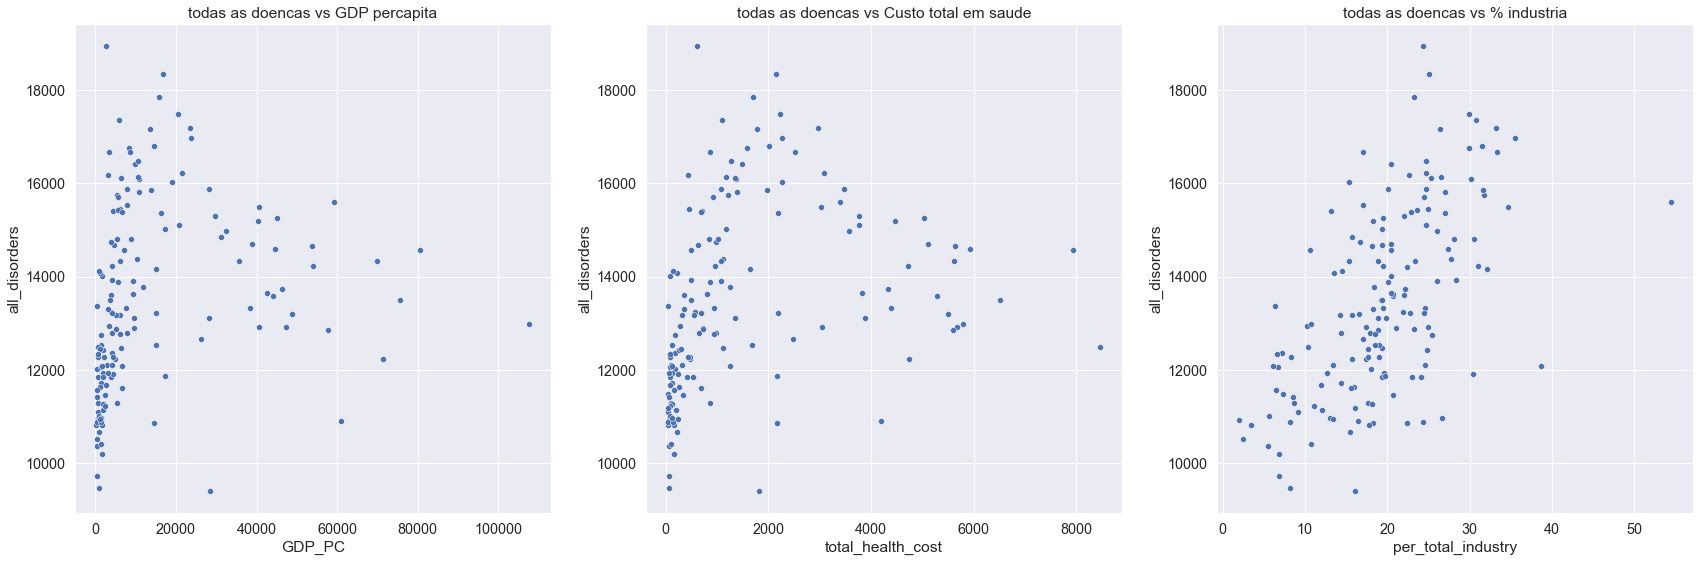

In [144]:

fig, axes = plt.subplots(1, 3, figsize=(29, 9))

sns.scatterplot(data=df_17_feat, x='GDP_PC',y= 'all_disorders', ax=axes[0]).set_title('todas as doencas vs GDP percapita')
sns.scatterplot(data=df_17_feat, x='total_health_cost',y= 'all_disorders', ax=axes[1]).set_title('todas as doencas vs Custo total em saude')
sns.scatterplot(data=df_17_feat, x='per_total_industry',y= 'all_disorders', ax=axes[2]).set_title('todas as doencas vs % industria')

plt.show()



In [147]:
df_17_feat.describe().T

count          mean           std          min  \
Dermatitis                 157.0   4768.037525    844.724435  2755.356948   
Musculoskeletal_disorders  157.0   4039.164143   1317.712702  2032.008510   
GDP_PC                     154.0  14207.364795  19318.796434   292.997631   
per_total_agriculture      157.0     24.982102     22.223413     0.060000   
per_total_employment       157.0     57.914522     11.509101    33.189999   
per_total_industry         157.0     19.492611      7.898400     1.970000   
per_total_services         157.0     55.526624     17.969138    10.220000   
mental_disorders           157.0   4652.974367   1224.596879  2011.980909   
total_health_cost          151.0   1529.857132   1827.833980    37.519101   
all_disorders              157.0  13460.176035   2022.573882  9399.809067   
Unemp_PC                   157.0      0.043023      0.029701     0.001152   
Week_hours_PC              156.0     39.723777      4.568705    24.763121   

                                    25%           50%           75%  \
Dermatitis                  4441.318473   4877.088127   5236.099278   
Musculoskeletal_disorders   2898.477911   4077.581955   4977.676623   
GDP_PC                      1862.066374   5759.222785  16723.603844   
per_total_agriculture          5.560000     18.480000     38.759998   
per_total_employment          49.599998     58.250000     65.040001   
per_total_industry            15.410000     19.379999     24.540001   
per_total_services            42.810001     58.799999     69.830002   
mental_disorders            3787.684519   4546.854334   5510.683400   
total_health_cost            186.617944    837.768982   2169.380463   
all_disorders              11917.457008  13208.057032  14987.158698   
Unemp_PC                       0.023400      0.035356      0.052351   
Week_hours_PC                 36.708340     39.591867     42.537114   

                                     max  
Dermatitis                   6626.683024  
Musculoskeletal_disorders    6725.235781  
GDP_PC                     107627.151007  
per_total_agriculture          86.309998  
per_total_employment           86.709999  
per_total_industry             54.509998  
per_total_services             87.849998  
mental_disorders             7769.331191  
total_health_cost            8466.585693  
all_disorders               18944.856987  
Unemp_PC                        0.163650  
Week_hours_PC                  52.412852

### Missing Values
(Using the Gradient Boosting)

In [145]:
pd.DataFrame({'#NA: 2017': df_17_feat.isna().sum()})

#NA: 2017
Dermatitis                         0
Musculoskeletal_disorders          0
GDP_PC                             3
per_total_agriculture              0
per_total_employment               0
per_total_industry                 0
per_total_services                 0
mental_disorders                   0
total_health_cost                  6
all_disorders                      0
Unemp_PC                           0
Week_hours_PC                      1

In [146]:
df_17_feat.loc[df_17_feat.isnull().any(axis=1)]

Dermatitis  Musculoskeletal_disorders        GDP_PC  \
location_name                                                                
Eritrea               4679.569806                2166.618721           NaN   
Guam                  5376.262523                5321.591138  35615.804627   
Libya                 4890.627687                4164.672267   5756.698450   
Montenegro            5625.437399                5989.258728   7784.087912   
Puerto Rico           5640.453543                4770.363208  31108.752751   
Somalia               4348.425869                2072.495370    309.055355   
South Sudan           4441.318473                2314.572942           NaN   
Syrian Arab Republic  4675.800606                4011.530808           NaN   

                      per_total_agriculture  per_total_employment  \
location_name                                                       
Eritrea                           64.889999             74.190002   
Guam                               0.250000             60.869999   
Libya                             17.580000             40.450001   
Montenegro                         7.940000             44.759998   
Puerto Rico                        1.130000             36.099998   
Somalia                           80.690002             41.310001   
South Sudan                       61.660000             63.590000   
Syrian Arab Republic              11.220000             40.500000   

                      per_total_industry  per_total_services  \
location_name                                                  
Eritrea                         7.350000           27.750000   
Guam                           15.310000           84.440002   
Libya                          23.620001           58.799999   
Montenegro                     17.080000           74.980003   
Puerto Rico                    15.680000           83.190002   
Somalia                         2.460000           16.840000   
South Sudan                    16.080000           22.270000   
Syrian Arab Republic           22.420000           66.360001   

                      mental_disorders  total_health_cost  all_disorders  \
location_name                                                              
Eritrea                    4631.311374          40.910640   11477.499901   
Guam                       3642.804994                NaN   14340.658655   
Libya                      6382.385393                NaN   15437.685347   
Montenegro                 3930.535277                NaN   15545.231405   
Puerto Rico                4434.755309                NaN   14845.572060   
Somalia                    4097.692861                NaN   10518.614101   
South Sudan                4418.141543          47.142034   11174.032958   
Syrian Arab Republic       5510.683400                NaN   14198.014814   

                      Unemp_PC  Week_hours_PC  
location_name                                  
Eritrea               0.051577            NaN  
Guam                  0.035356      42.518226  
Libya                 0.092492      43.942724  
Montenegro            0.085717      42.917924  
Puerto Rico           0.043708      38.002861  
Somalia               0.061845      36.250964  
South Sudan           0.088619      36.192864  
Syrian Arab Republic  0.036802      42.196742

In [148]:
df_17_gb = (
    df_17_feat
    .pipe(predict_missing, 'total_health_cost')
    .pipe(predict_missing, 'GDP_PC')
    .pipe(predict_missing, 'Week_hours_PC')
)

In [150]:
df_17_gb.loc[df_17_feat.isnull().any(axis=1)]

Dermatitis  Musculoskeletal_disorders        GDP_PC  \
location_name                                                                
Eritrea               4679.569806                2166.618721   1116.161288   
Guam                  5376.262523                5321.591138  35615.804627   
Libya                 4890.627687                4164.672267   5756.698450   
Montenegro            5625.437399                5989.258728   7784.087912   
Puerto Rico           5640.453543                4770.363208  31108.752751   
Somalia               4348.425869                2072.495370    309.055355   
South Sudan           4441.318473                2314.572942    871.043129   
Syrian Arab Republic  4675.800606                4011.530808   7126.010335   

                      per_total_agriculture  per_total_employment  \
location_name                                                       
Eritrea                           64.889999             74.190002   
Guam                               0.250000             60.869999   
Libya                             17.580000             40.450001   
Montenegro                         7.940000             44.759998   
Puerto Rico                        1.130000             36.099998   
Somalia                           80.690002             41.310001   
South Sudan                       61.660000             63.590000   
Syrian Arab Republic              11.220000             40.500000   

                      per_total_industry  per_total_services  \
location_name                                                  
Eritrea                         7.350000           27.750000   
Guam                           15.310000           84.440002   
Libya                          23.620001           58.799999   
Montenegro                     17.080000           74.980003   
Puerto Rico                    15.680000           83.190002   
Somalia                         2.460000           16.840000   
South Sudan                    16.080000           22.270000   
Syrian Arab Republic           22.420000           66.360001   

                      mental_disorders  total_health_cost  all_disorders  \
location_name                                                              
Eritrea                    4631.311374          40.910640   11477.499901   
Guam                       3642.804994        4027.872249   14340.658655   
Libya                      6382.385393         658.580068   15437.685347   
Montenegro                 3930.535277        1488.777693   15545.231405   
Puerto Rico                4434.755309        2962.644691   14845.572060   
Somalia                    4097.692861         -27.362082   10518.614101   
South Sudan                4418.141543          47.142034   11174.032958   
Syrian Arab Republic       5510.683400        1103.179112   14198.014814   

                      Unemp_PC  Week_hours_PC  
location_name                                  
Eritrea               0.051577      32.846900  
Guam                  0.035356      42.518226  
Libya                 0.092492      43.942724  
Montenegro            0.085717      42.917924  
Puerto Rico           0.043708      38.002861  
Somalia               0.061845      36.250964  
South Sudan           0.088619      36.192864  
Syrian Arab Republic  0.036802      42.196742

### 1. Remove Outliers

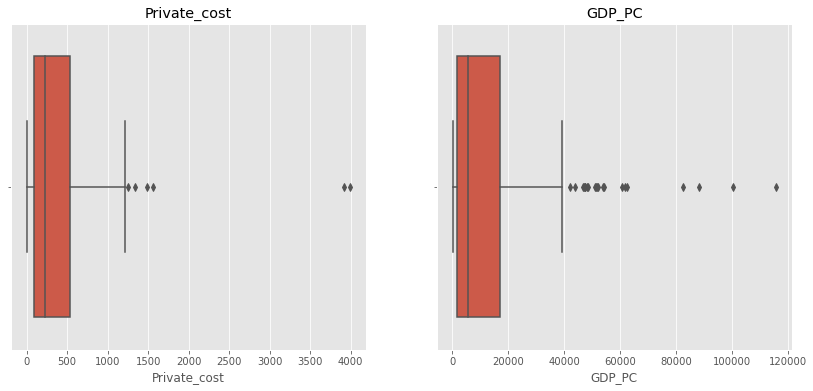

skew       kurt
Anxiety_disorder           0.550010   0.608307
Bipolar_disorder           0.251188   0.371838
Depressive_disorders       0.468465   0.085916
Dermatitis                -0.361964  -0.284530
Musculoskeletal_disorders  0.307942  -0.931164
Public_cost                1.839094   2.719467
Private_cost               4.235344  24.995237
GDP_PC                     2.219867   5.422459
per_total_agriculture      0.653955  -0.703915
per_total_employment       0.285899  -0.274244
per_total_industry         0.329752   0.970704
per_total_services        -0.306074  -0.893237
Total_Labor_Force          0.260776  -0.239545
Unemployment_rate          1.412328   1.929349
Weekly_work_hours          9.200545  91.542004
Pop_Over15                 8.163477  70.268097
Week_hours_PC              0.985382   1.945901

In [30]:
eval_outliers(df_11,['Private_cost','GDP_PC'])

In [65]:
# Remove outliers as per plots above:Private_cost > 3500 & GDP_per_cap > 80000)
df_11_no = df_11.drop(df_11[df_11['Private_cost'] > 3500].index)
df_11_no.drop(df_11_no[df_11_no['GDP_PC'] > 80000].index,inplace = True)

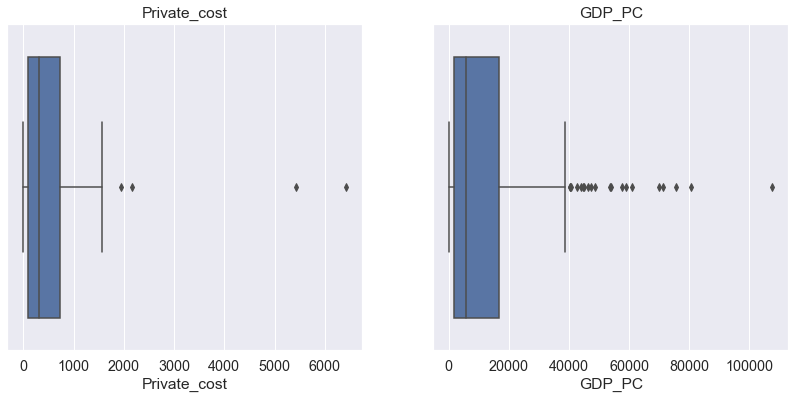

skew       kurt
Anxiety_disorder           0.363360   0.183601
Bipolar_disorder           0.171680   0.250780
Depressive_disorders       0.244546  -0.390099
Dermatitis                -0.467853  -0.241363
Musculoskeletal_disorders  0.229870  -0.958559
Public_cost                1.631219   1.799283
Private_cost               4.846133  31.773842
GDP_PC                     2.105048   4.674310
per_total_agriculture      0.849607  -0.275752
per_total_employment       0.155255  -0.351983
per_total_industry         0.433400   1.693261
per_total_services        -0.411677  -0.691903
Total_Labor_Force          0.095587  -0.289128
Unemployment_rate          1.377546   1.662054
Weekly_work_hours          9.019097  87.987014
Pop_Over15                 8.027957  67.560391
Week_hours_PC              0.982989   1.965291

In [66]:
df_17 = merge2complete('2017')
eval_outliers(df_17,['Private_cost','GDP_PC'])

In [67]:
#let's see if we have the same outliers in both data-sets:

# For 2011

pd.concat([df_11.loc[df_11.Private_cost > 3500],df_11.loc[df_11.GDP_PC > 80000]])

Anxiety_disorder  Bipolar_disorder  Depressive_disorders  \
location_name                                                             
Liberia              546.592086         49.656894           4183.597501   
Switzerland          828.742223         62.869998           4806.902201   
Luxembourg           735.714819         61.670868           3880.999183   
Norway               907.309019         59.554391           3526.220844   
Qatar                703.244860         61.305339           5466.014379   
Switzerland          828.742223         62.869998           4806.902201   

                Dermatitis  Musculoskeletal_disorders  Public_cost  \
location_name                                                        
Liberia        4791.624410                2364.788293  1235.321289   
Switzerland    3253.039580                5676.299312  1924.072510   
Luxembourg     3291.846818                4910.542012  4802.062988   
Norway         3604.407771                5091.140820  4636.580566   
Qatar          5052.915012                4378.810274  1459.370605   
Switzerland    3253.039580                5676.299312  1924.072510   

               Private_cost         GDP_PC  per_total_agriculture  \
location_name                                                       
Liberia         3986.635742     596.897081              46.439999   
Switzerland     3916.969971   88415.628032               3.510000   
Luxembourg       944.476929  115761.507705               1.230000   
Norway           855.496582  100600.562408               2.370000   
Qatar            524.975403   82409.577333               1.360000   
Switzerland     3916.969971   88415.628032               3.510000   

               per_total_employment  per_total_industry  per_total_services  \
location_name                                                                 
Liberia                   73.839996           10.810000           42.750000   
Switzerland               64.489998           22.280001           74.209999   
Luxembourg                54.070000           13.360000           85.410004   
Norway                    63.110001           20.250000           77.379997   
Qatar                     86.330002           54.110001           44.540001   
Switzerland               64.489998           22.280001           74.209999   

               Total_Labor_Force  Unemployment_rate  Weekly_work_hours  \
location_name                                                            
Liberia                75.529999               2.24         74613436.0   
Switzerland            67.459999               4.40        161090739.0   
Luxembourg             56.849998               4.90          8810917.0   
Norway                 65.199997               3.22         87927758.0   
Qatar                  86.820000               0.56         76430339.0   
Switzerland            67.459999               4.40        161090739.0   

               Pop_Over15  Week_hours_PC  
location_name                             
Liberia         2291263.0      32.564326  
Switzerland     6728881.0      23.940197  
Luxembourg       428148.0      20.579139  
Norway          4027931.0      21.829509  
Qatar           1769481.0      43.193648  
Switzerland     6728881.0      23.940197

In [68]:
# For 2017

pd.concat([df_17.loc[df_17.Private_cost > 3500],df_17.loc[df_17.GDP_PC > 65000]])

Anxiety_disorder  Bipolar_disorder  Depressive_disorders  \
location_name                                                             
Liberia              569.510978         51.687567           4411.779660   
Switzerland          802.672186         61.433026           4722.200520   
Iceland              716.632742         61.883138           3205.778103   
Ireland              900.031276         49.971683           5251.469469   
Luxembourg           715.824326         60.967736           3890.642072   
Norway               879.752571         58.813050           3787.399463   
Switzerland          802.672186         61.433026           4722.200520   

                Dermatitis  Musculoskeletal_disorders  Public_cost  \
location_name                                                        
Liberia        4933.904862                2528.758085  2044.470947   
Switzerland    3222.047159                5755.426880  2501.819824   
Iceland        3265.699416                4977.676623  3880.167480   
Ireland        3260.744705                4876.256807  4088.266846   
Luxembourg     3288.160994                5022.600800  4976.985840   
Norway         3596.558229                5178.138695  5546.387695   
Switzerland    3222.047159                5755.426880  2501.819824   

               Private_cost         GDP_PC  per_total_agriculture  \
location_name                                                       
Liberia         6422.114746     698.701764              43.220001   
Switzerland     5426.354492   80449.994513               3.110000   
Iceland          859.566650   71310.939256               3.760000   
Ireland         1528.564941   69822.347085               5.050000   
Luxembourg       812.346924  107627.151007               1.390000   
Norway           969.524353   75496.754058               2.060000   
Switzerland     5426.354492   80449.994513               3.110000   

               per_total_employment  per_total_industry  per_total_services  \
location_name                                                                 
Liberia                   74.250000               10.39           46.400002   
Switzerland               65.099998               20.52           76.379997   
Iceland                   74.540001               17.48           78.760002   
Ireland                   58.020000               18.84           76.110001   
Luxembourg                55.430000               10.76           87.849998   
Norway                    60.950001               19.41           78.529999   
Switzerland               65.099998               20.52           76.379997   

               Total_Labor_Force  Unemployment_rate  Weekly_work_hours  \
location_name                                                            
Liberia                76.540001               3.00         90190027.0   
Switzerland            68.379997               4.80        170813602.0   
Iceland                76.639999               2.74          7935561.0   
Ireland                62.200001               6.71         78306739.0   
Luxembourg             58.669998               5.52         10365801.0   
Norway                 63.599998               4.16         91419749.0   
Switzerland            68.379997               4.80        170813602.0   

               Pop_Over15  Week_hours_PC  
location_name                             
Liberia         2751804.0      32.774873  
Switzerland     7194841.0      23.741123  
Iceland          274756.0      28.882212  
Ireland         3768835.0      20.777439  
Luxembourg       500534.0      20.709484  
Norway          4344523.0      21.042528  
Switzerland     7194841.0      23.741123

In [69]:
#For simplification, let's remove the same outliers for 2017 as in 2011
#df_17_no = df_17.drop(index = ['Liberia','Switzerland','Luxembourg','Norway','Qatar','Switzerland'])
df_17_no = df_17.drop(df_17[df_17['Private_cost'] > 3500].index)
df_17_no.drop(df_17_no[df_17_no['GDP_PC'] > 65000].index,inplace = True)

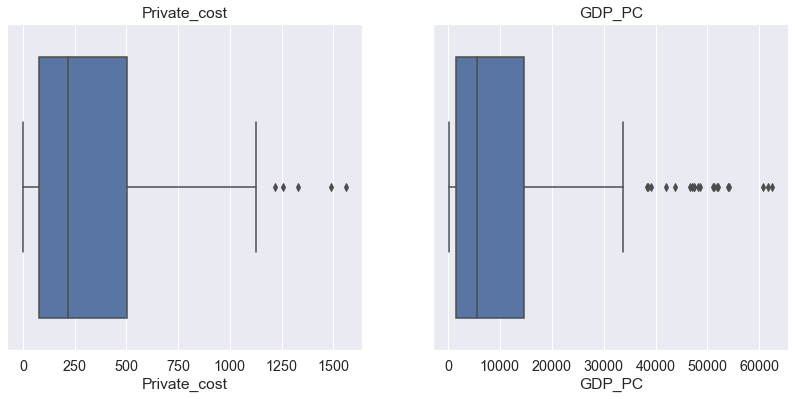

skew       kurt
Anxiety_disorder           0.578913   0.789370
Bipolar_disorder           0.268552   0.299594
Depressive_disorders       0.493887   0.087023
Dermatitis                -0.381034  -0.181959
Musculoskeletal_disorders  0.348836  -0.884692
Public_cost                1.790133   2.231854
Private_cost               1.438502   1.807212
GDP_PC                     1.607609   1.422193
per_total_agriculture      0.639339  -0.717254
per_total_employment       0.279086  -0.288685
per_total_industry        -0.104446  -0.577817
per_total_services        -0.318386  -0.902726
Total_Labor_Force          0.251715  -0.248355
Unemployment_rate          1.384824   1.835929
Weekly_work_hours          9.054090  88.623239
Pop_Over15                 8.033515  68.004959
Week_hours_PC              0.748841   1.134059

In [70]:
#Re-evaluate whiskers, skew and kurt:
eval_outliers(df_11_no,['Private_cost','GDP_PC'])

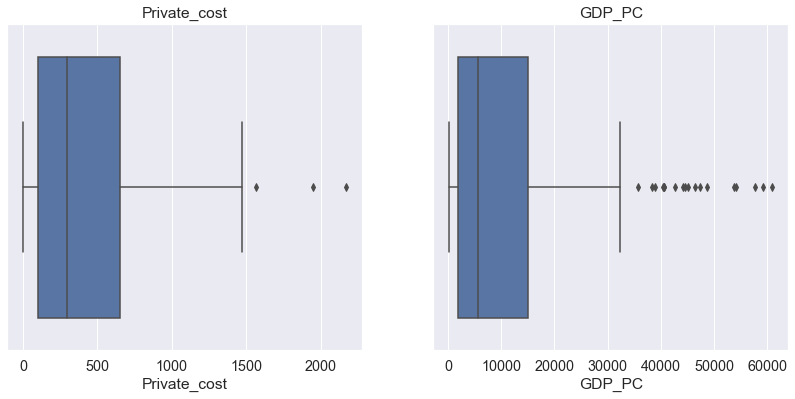

skew       kurt
Anxiety_disorder           0.371469   0.341579
Bipolar_disorder           0.185766   0.158383
Depressive_disorders       0.260575  -0.420220
Dermatitis                -0.519416   0.019923
Musculoskeletal_disorders  0.284081  -0.913286
Public_cost                1.733676   2.224173
Private_cost               1.366832   1.586468
GDP_PC                     1.672281   1.837518
per_total_agriculture      0.827273  -0.308811
per_total_employment       0.189692  -0.333997
per_total_industry         0.406028   1.626163
per_total_services        -0.410220  -0.692092
Total_Labor_Force          0.124323  -0.279483
Unemployment_rate          1.326411   1.489092
Weekly_work_hours          8.847157  84.625968
Pop_Over15                 7.873519  64.929589
Week_hours_PC              1.002252   2.108566

In [71]:
eval_outliers(df_17_no,['Private_cost','GDP_PC'])

### Fill out NA's

In [72]:
pd.DataFrame({'#NA: 2011': df_11_no.isna().sum(), '#NA: 2017':df_17_no.isna().sum()})

#NA: 2011  #NA: 2017
Anxiety_disorder                   0          0
Bipolar_disorder                   0          0
Depressive_disorders               0          0
Dermatitis                         0          0
Musculoskeletal_disorders          0          0
Public_cost                        5          6
Private_cost                       5          6
GDP_PC                             2          3
per_total_agriculture              0          0
per_total_employment               0          0
per_total_industry                 0          0
per_total_services                 0          0
Total_Labor_Force                  0          0
Unemployment_rate                  0          0
Weekly_work_hours                  0          0
Pop_Over15                         0          1
Week_hours_PC                      0          1

In [73]:
df_11_gb = (
    df_11_no
    .pipe(predict_missing, 'Public_cost')
    .pipe(predict_missing, 'Private_cost')
    .pipe(predict_missing, 'GDP_PC')
)

df_17_gb = (
    df_17_no
    .pipe(predict_missing, 'Public_cost')
    .pipe(predict_missing, 'Private_cost')
    .pipe(predict_missing, 'GDP_PC')
    .pipe(predict_missing, 'Pop_Over15')
    .pipe(predict_missing, 'Week_hours_PC')
)

In [103]:
df_11_gb[df_11_gb.index == 'United Kingdom']

Dermatitis  Musculoskeletal_disorders       GDP_PC  \
location_name                                                         
United Kingdom  3420.061128                5744.642735  42038.57225   

                per_total_employment  Weekly_work_hours  Pop_Over15  \
location_name                                                         
United Kingdom             56.830002       1.066587e+09  52156355.0   

                Week_hours_PC  mental_disorders  total_health_cost  \
location_name                                                        
United Kingdom      20.449797       5819.675442        3719.872803   

                all_disorders  agriculture_PC  industry_PC  services_PC  \
location_name                                                             
United Kingdom   14984.379305        0.006933        0.109     0.452367   

                Unemp_PC  
location_name             
United Kingdom  0.049679

In [74]:
pd.DataFrame({'#NA: 2011': df_11_gb.isna().sum(), '#NA: 2017':df_17_gb.isna().sum()})

#NA: 2011  #NA: 2017
Anxiety_disorder                   0          0
Bipolar_disorder                   0          0
Depressive_disorders               0          0
Dermatitis                         0          0
Musculoskeletal_disorders          0          0
Public_cost                        0          0
Private_cost                       0          0
GDP_PC                             0          0
per_total_agriculture              0          0
per_total_employment               0          0
per_total_industry                 0          0
per_total_services                 0          0
Total_Labor_Force                  0          0
Unemployment_rate                  0          0
Weekly_work_hours                  0          0
Pop_Over15                         0          0
Week_hours_PC                      0          0

### Feature Engineering

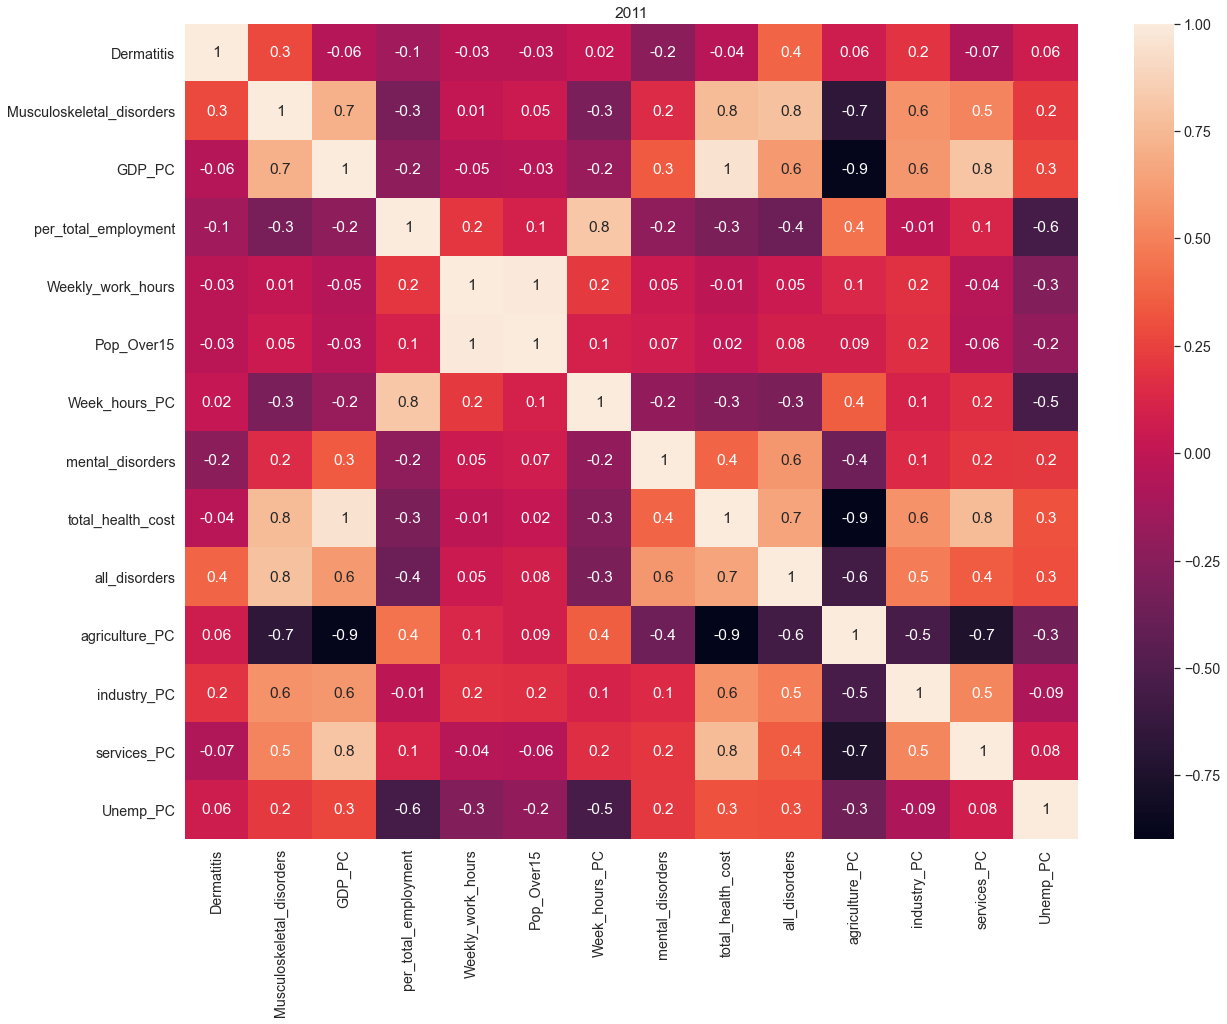

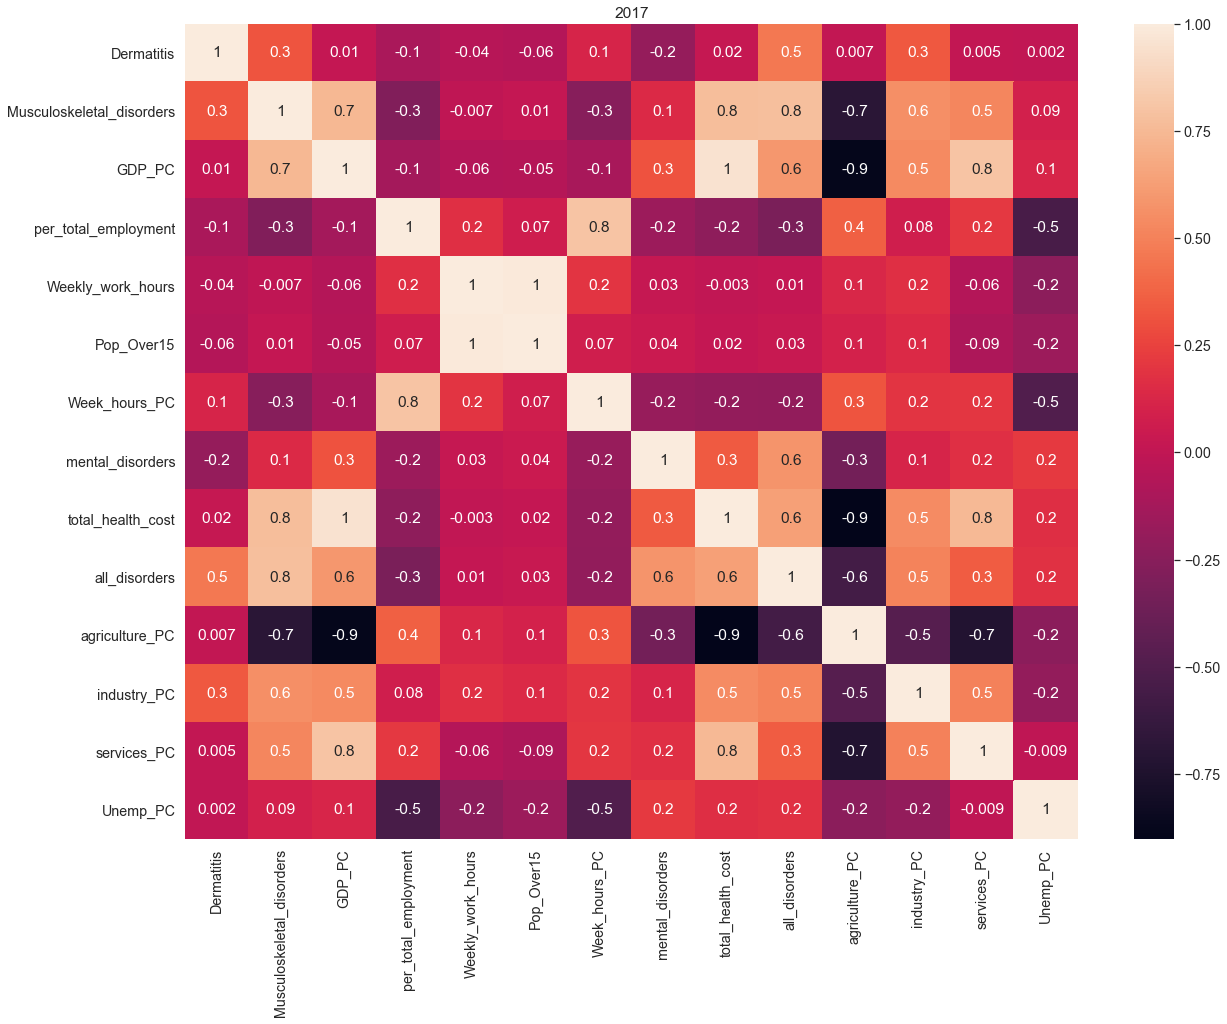

In [75]:
df_11_feat = feature_df(df_11_gb,'2011')
df_17_feat = feature_df(df_17_gb,'2017')

In [ ]:
eval_outliers(df_11_no,['industry_PC'])

### Cluster Analysis

Scenario 1: __Delta between 2011 and 2017__, considering the following features:

1. Per_Total_employment
2. Unem_percapita
3. Week_hours_PC
4. GDP_per_cap
5. Total_health_cost
6. All_disorders

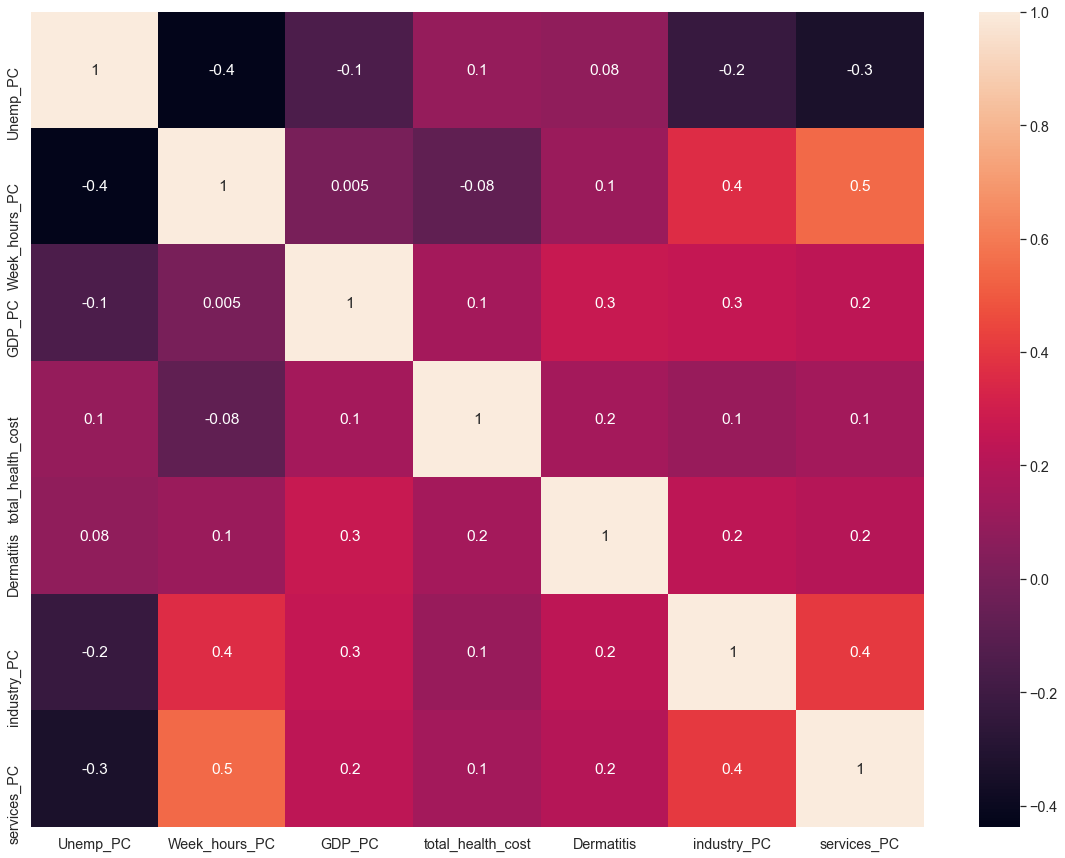

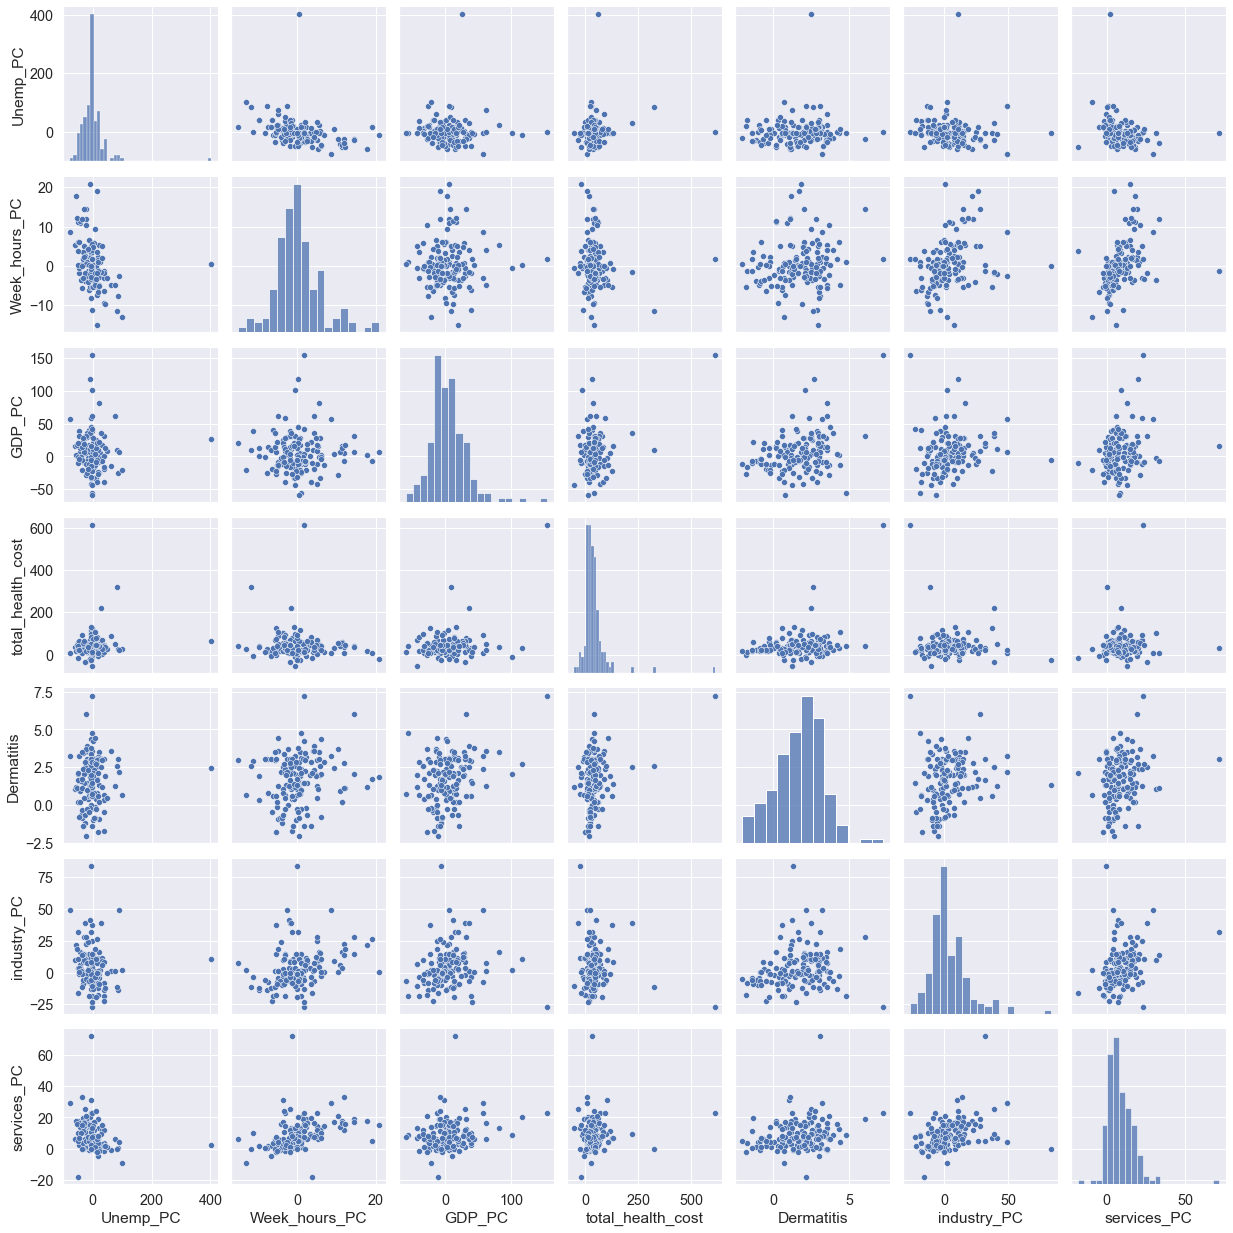

count       mean        std        min        25%  \
Unemp_PC           150.0  -0.708205  44.138319 -76.879646 -19.892090   
Week_hours_PC      150.0   0.367849   5.754436 -15.004738  -3.077706   
GDP_PC             150.0   5.244289  28.816402 -58.867580 -11.439277   
total_health_cost  150.0  40.745374  62.144710 -52.826425  16.009676   
Dermatitis         150.0   1.696187   1.580597  -2.072197   0.671930   
industry_PC        150.0   3.624432  15.230344 -26.879486  -5.820034   
services_PC        150.0   8.745317   9.261364 -18.188675   2.989158   

                         50%        75%         max  
Unemp_PC           -4.297961  10.834884  403.013315  
Week_hours_PC      -0.105668   2.336669   20.831629  
GDP_PC              1.880966  17.378071  154.617794  
total_health_cost  30.833814  47.476339  612.598884  
Dermatitis          1.916097   2.864269    7.245659  
industry_PC         0.941133  10.460380   83.868529  
services_PC         7.075088  13.228073   71.794926

In [76]:
#df_sc_1 = (100*(df_17_feat - df_11_feat)/(df_11_feat))[['Unemp_PC','Week_hours_PC',\
#                                                'GDP_PC','total_health_cost','Dermatitis','industry_PC','services_PC']]

    
    
#correlation map
#sns.set(font_scale=1.3)
#df_corr = df_sc_1.corr(method = 'spearman')
#figure = plt.figure(figsize=(20,15))
#sns.heatmap(df_corr, annot=True, fmt = '.1g')

#sns.pairplot(df_sc_1)

#plt.show()

#df_sc_1.describe().T

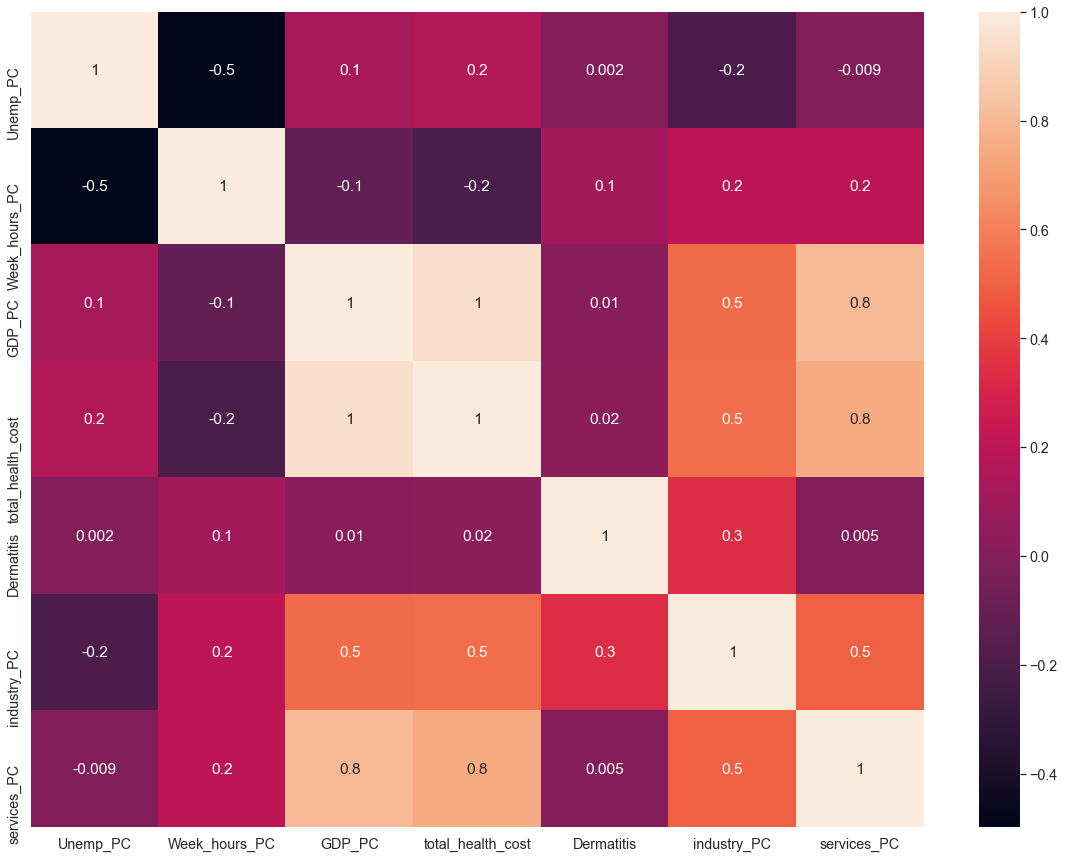

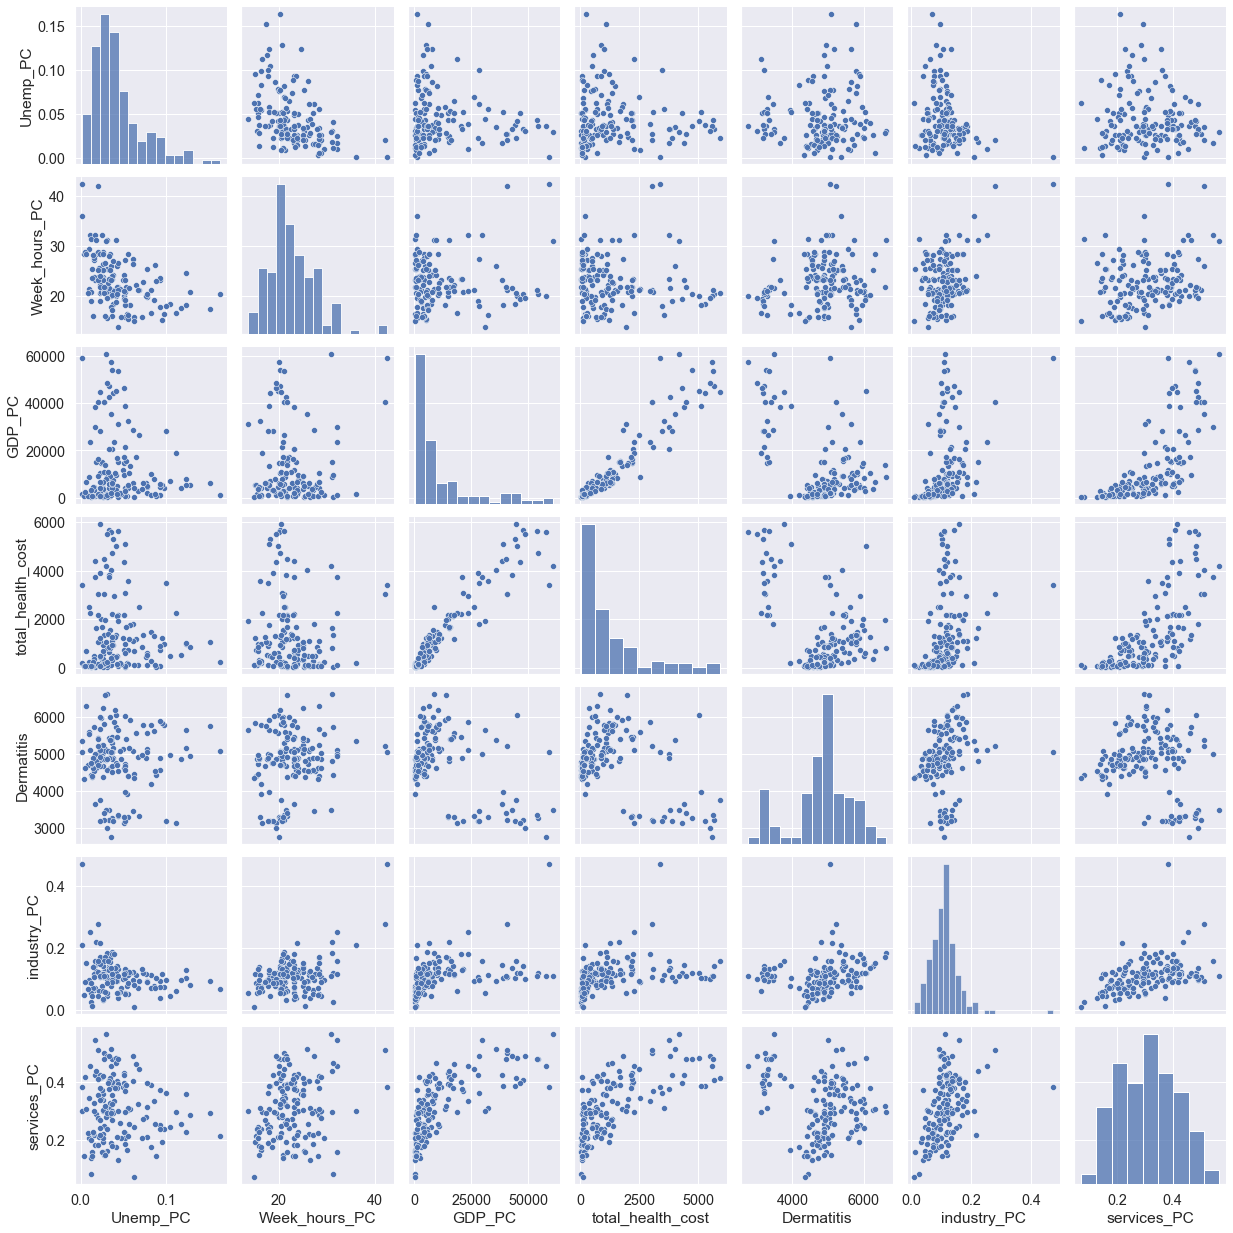

count          mean           std          min  \
Unemp_PC           151.0      0.043558      0.030132     0.001152   
Week_hours_PC      151.0     22.776324      4.922005    13.719032   
GDP_PC             151.0  11857.156408  14895.241057   292.997631   
total_health_cost  151.0   1334.761595   1517.044583    37.519101   
Dermatitis         151.0   4814.667391    818.445633  2755.356948   
industry_PC        151.0      0.110814      0.052585     0.010162   
services_PC        151.0      0.309206      0.106278     0.069566   

                           25%          50%           75%           max  
Unemp_PC              0.023907     0.035849      0.053894      0.163650  
Week_hours_PC        19.976495    21.812480     25.349827     42.487776  
GDP_PC             1695.948704  5637.514946  15064.945414  60913.745333  
total_health_cost   181.869697   805.257263   1876.207836   5930.576172  
Dermatitis         4533.051332  4884.982232   5327.065424   6626.683024  
industry_PC           0.079203     0.109213      0.130536      0.472656  
services_PC           0.221615     0.300316      0.392864      0.567868

In [82]:
df_sc_1 = (df_17_feat)[['Unemp_PC','Week_hours_PC',\
                                                'GDP_PC','total_health_cost','Dermatitis','industry_PC','services_PC']]

    
    
#correlation map
sns.set(font_scale=1.3)
df_corr = df_sc_1.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g')

sns.pairplot(df_sc_1)

plt.show()

df_sc_1.describe().T

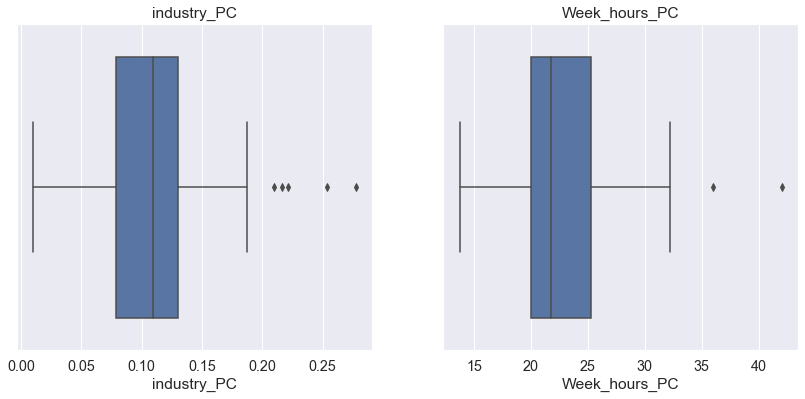

skew      kurt
Unemp_PC           1.484003  2.408511
Week_hours_PC      0.759363  1.283285
GDP_PC             1.709021  2.003077
total_health_cost  1.499097  1.368418
Dermatitis        -0.512254 -0.000745
industry_PC        0.684740  1.658139
services_PC        0.139317 -0.709277

In [93]:
eval_outliers(df_sc_1,['industry_PC','Week_hours_PC'])

In [92]:
df_sc_1.drop(df_sc_1[df_sc_1['industry_PC'] > 0.4].index,inplace = True)

C:\Users\lsove\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


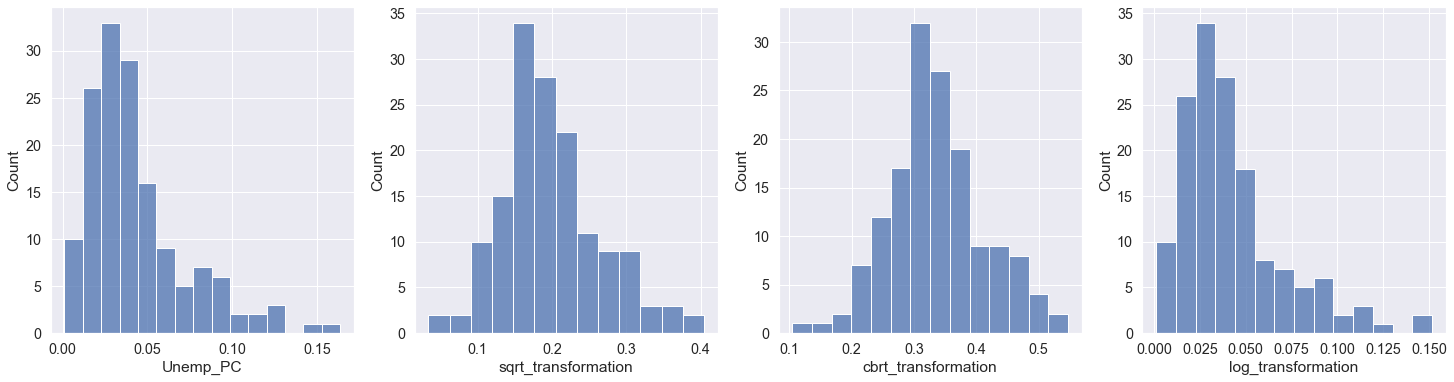

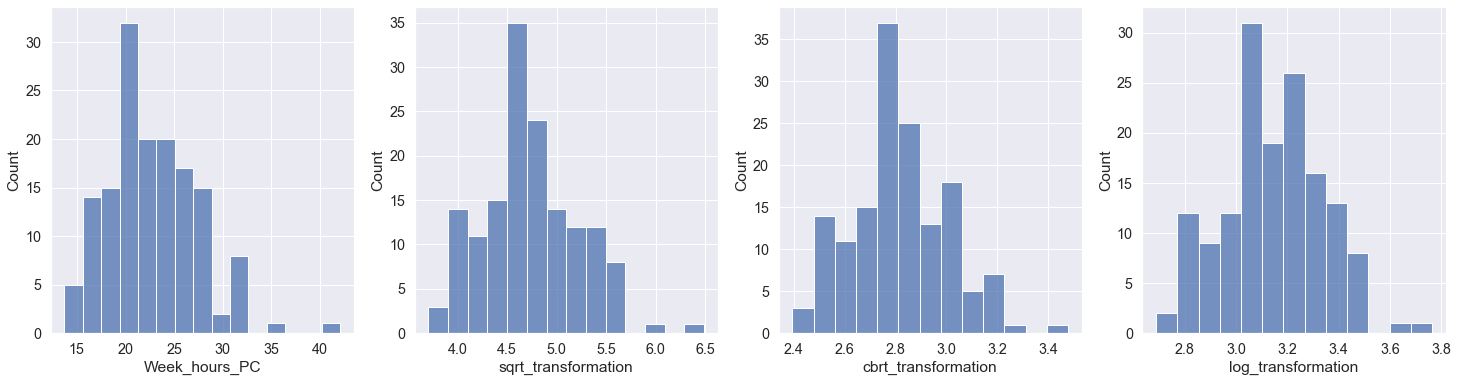

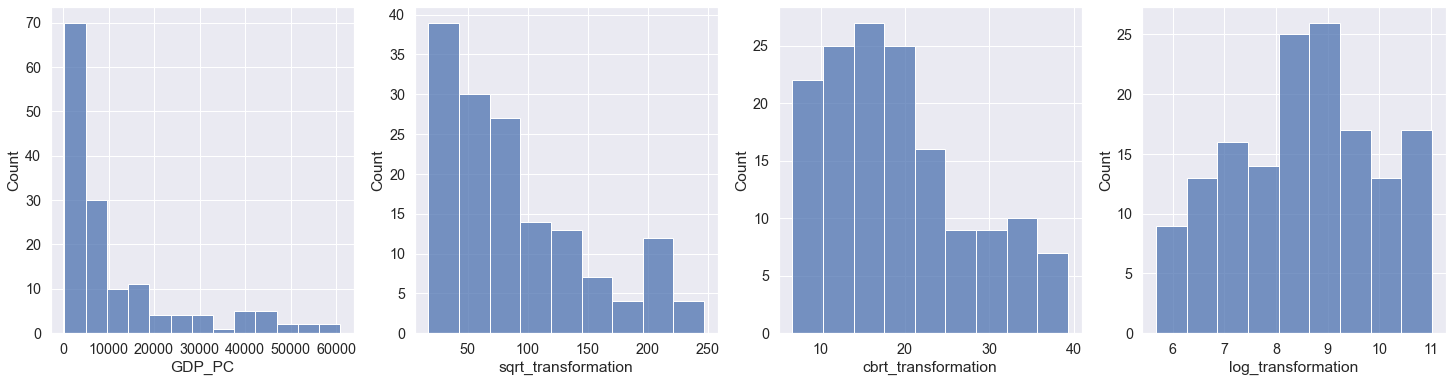

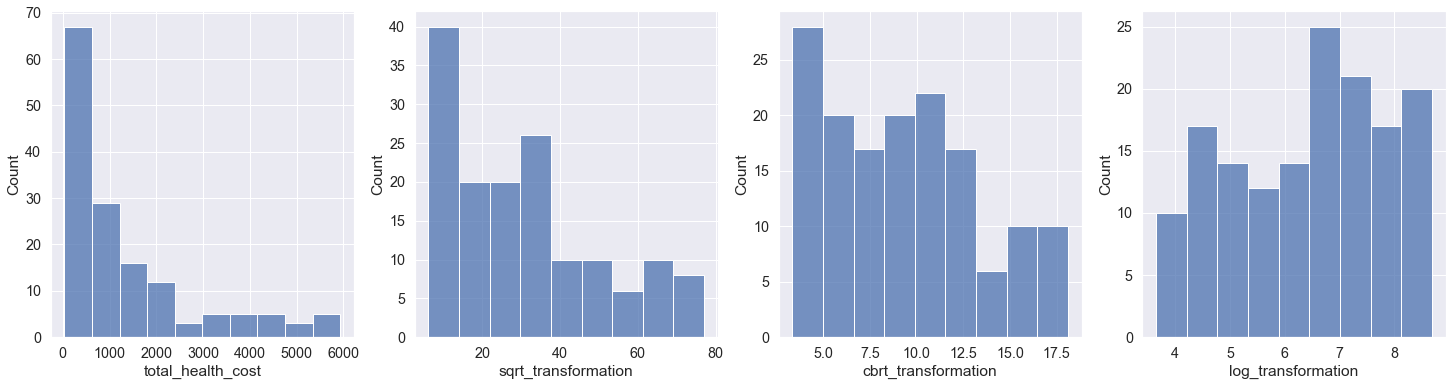

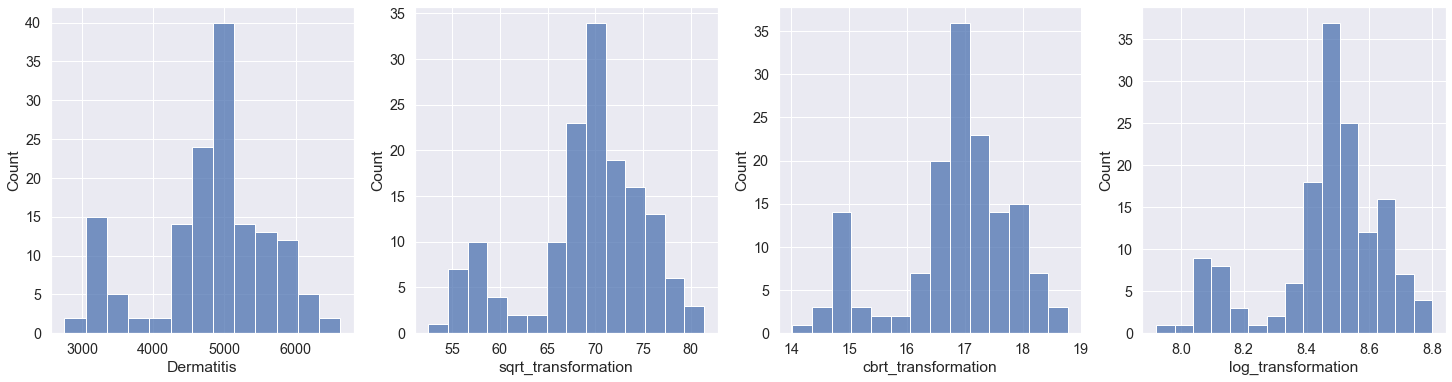

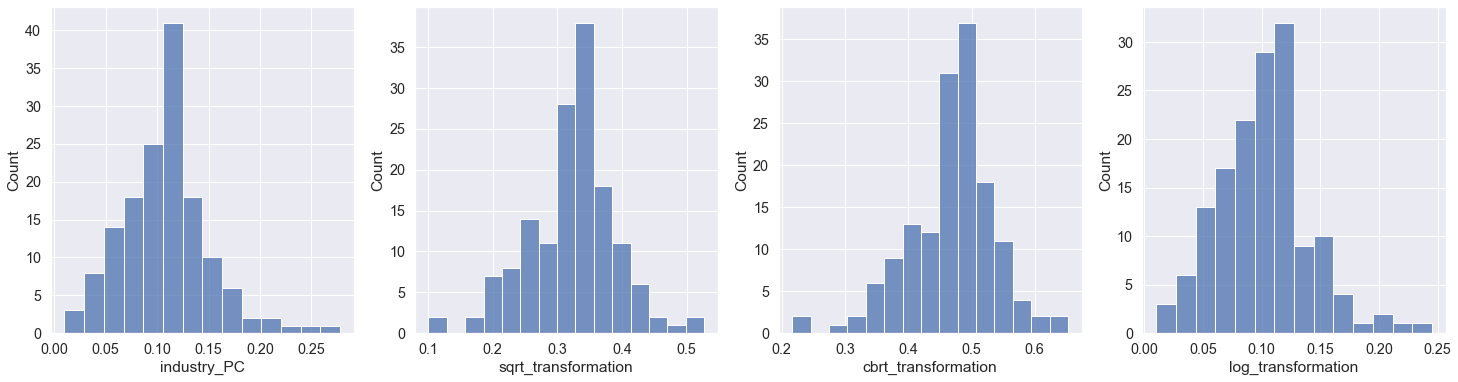

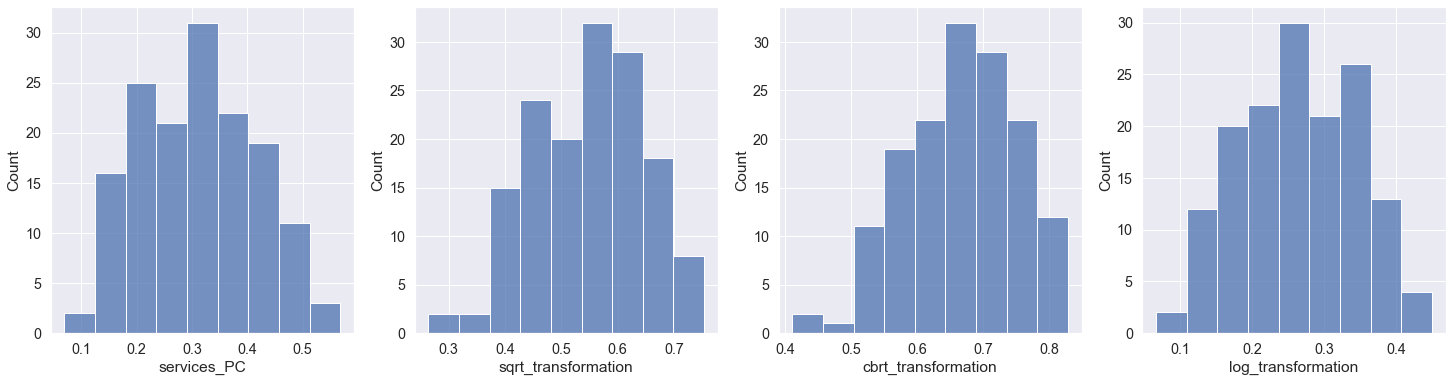

In [94]:
pt_evaluation(df_sc_1, 'Unemp_PC')
pt_evaluation(df_sc_1, 'Week_hours_PC')
pt_evaluation(df_sc_1, 'GDP_PC')
pt_evaluation(df_sc_1, 'total_health_cost')
pt_evaluation(df_sc_1, 'Dermatitis')
pt_evaluation(df_sc_1, 'industry_PC')
pt_evaluation(df_sc_1, 'services_PC')

In [98]:
df_sc1_t = df_sc_1[[]]
df_sc1_t = df_sc1_t.assign(Unemp_PC_cb = np.cbrt(df_sc_1['Unemp_PC']))
df_sc1_t = df_sc1_t.assign(Week_hours_PC_cb = np.cbrt(df_sc_1['Week_hours_PC'] + 1))
df_sc1_t = df_sc1_t.assign(GDP_PC_log = np.log(df_sc_1['GDP_PC'] + 1))
df_sc1_t = df_sc1_t.assign(total_health_cost_log = np.cbrt(df_sc_1['total_health_cost']))
df_sc1_t = df_sc1_t.assign(industry_PC_sq = np.sqrt(df_sc_1['industry_PC']))
df_sc1_t = df_sc1_t.assign(Dermatitis_norm = (df_sc_1['Dermatitis']))
df_sc1_t = df_sc1_t.assign(services_PC_norm = (df_sc_1['services_PC']))

In [99]:
minmax = MinMaxScaler()
minmax_sc1 = pd.DataFrame(minmax.fit_transform(df_sc_1), columns=df_sc_1.columns)

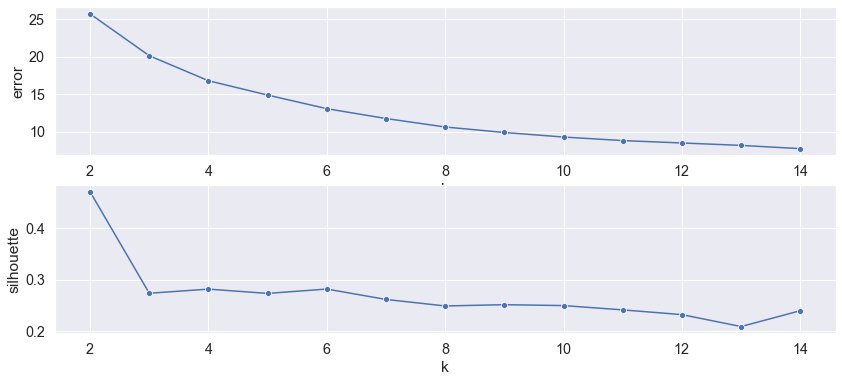

In [100]:
evaluate_number_clusters(minmax_sc1,15)

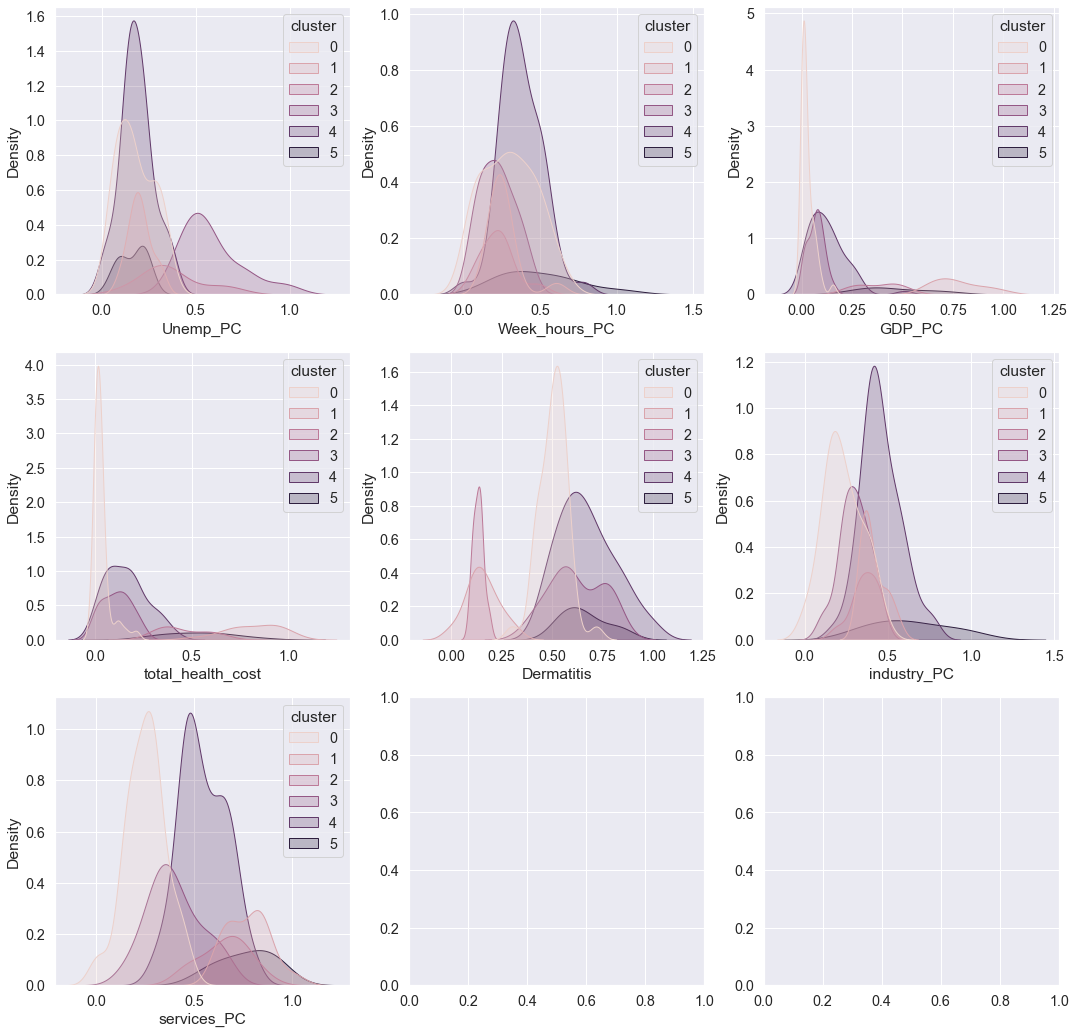

labels Unemp_PC        Week_hours_PC           GDP_PC            \
        count     mean median          mean median      mean    median   
labels                                                                   
0          42     0.03   0.03         22.22  21.74   1894.68   1288.97   
1          14     0.03   0.03         21.15  20.42  47021.66  45444.74   
2          10     0.06   0.05         20.16  20.32  23093.48  23914.56   
3          25     0.10   0.09         19.99  19.99   4538.21   4531.02   
4          50     0.03   0.03         24.30  23.85   7884.43   6590.00   
5           9     0.03   0.03         27.89  25.88  28312.74  23742.99   

       total_health_cost          Dermatitis          industry_PC         \
                    mean   median       mean   median        mean median   
labels                                                                     
0                 213.70   129.04    4714.48  4720.49        0.07   0.07   
1                4835.42  4917.79    3348.39  3303.46        0.12   0.11   
2                2712.87  2378.92    3271.16  3290.43        0.11   0.11   
3                 683.65   680.08    5152.09  5058.86        0.09   0.09   
4                 971.22   936.83    5354.68  5264.10        0.13   0.13   
5                3189.51  3031.25    5313.12  5220.40        0.18   0.18   

       services_PC         
              mean median  
labels                     
0             0.19   0.20  
1             0.45   0.47  
2             0.39   0.41  
3             0.27   0.25  
4             0.34   0.33  
5             0.45   0.45

In [101]:
evaluate_cluster(minmax_sc1, df_sc_1, 6)